<div class="header" style="text-align: center; margin-top: 20px; margin-bottom: 20px; font-family: Arial, sans-serif;">
    <h1> Bachelor Thesis</h1>
</div>
<div style="text-align: justified; margin-bottom: 20px; font-family: Arial, sans-serif;">
    <p> This notebook is devoted to the analysis and plotting of the data generated during my research as part of my Bachelor thesis at Yachay Tech University, Ecuador. The thesis is titled <i>"First Principles and Machine Learning Investigations into the Atomic and Mechanical Properties of Cement Hydrates"</i> and was supervised by Dr. Henry Pinto. 
    </p>
</div>

In [105]:
# Import Libraries
import matplotlib.pyplot as plt
from matplotlib.ticker import ScalarFormatter
import scienceplots
import pandas as pd
import numpy as np
from sympy import symbols, Eq, init_printing
from sympy.abc import x
from IPython.display import display
from scipy.optimize import curve_fit
from tabulate import tabulate
init_printing()  # Enables pretty printing in LaTeX

In [106]:
# Colout palette
dataset_colors = ['#9671bd', '#7e7e7e', '#77b5b6', '#c27c7c', '#7a9ec9', '#d7a87a', '#7fb79f']
dataset_line_colors = ['#6a408d', '#4e4e4e', '#378d94', '#8f5656', '#4d6990', '#a37146', '#4d7a63']
regression_color = '#8a8a8a' # <-- neutral grey

# Font settings and style
plt.rcParams.update({
    'font.family': 'Courier New',   
    'font.size': 20,
    'axes.titlesize': 20,
    'axes.labelsize': 20,
    'xtick.labelsize': 20,
    'ytick.labelsize': 20,
    'legend.fontsize': 20,
    'figure.titlesize': 20,
    
    # Ensure math uses the same font
    'mathtext.fontset': 'custom',
    'mathtext.rm': 'Courier New',
    'mathtext.it': 'Courier New:italic',
    'mathtext.bf': 'Courier New:bold',
})

<div class="header" style="text-align: center; margin-top: 20px; margin-bottom: 20px; font-family: Arial, sans-serif;">
    <h2>Kpoint mesh grid</h2>
</div>

In [107]:
class ReadPoscarFile:
    def __init__(self, file_path):
        self.lattice_vectors = None  # set before anything uses it
        self.volume = None
        self.n_atoms = None
        self._GetPoscar(file_path)   # now this will populate values correctly
        self._GetVolume()            # calculate volume now that vectors are set


    def _GetPoscar(self, file_path):
        with open(file_path, 'r') as file:
            lines = file.readlines()
            self._GetLatticeVectors(lines)
            self.n_atoms = sum(list(map(int, lines[6].split())))

    def _GetLatticeVectors(self, lines):
        self.lattice_vectors = {
            'a': np.array([float(x) for x in lines[2].split()]),
            'b': np.array([float(x) for x in lines[3].split()]),
            'c': np.array([float(x) for x in lines[4].split()])
        }

        scale = float(lines[1])

        self.lattice_vectors['a'] *= scale
        self.lattice_vectors['b'] *= scale
        self.lattice_vectors['c'] *= scale

    def _GetVolume(self):
        self.volume = np.dot(np.cross(
                                    self.lattice_vectors['a'],
                                    self.lattice_vectors['b']),
                                    self.lattice_vectors['c']
                                    )

In [108]:
# POSCAR file path
POSCAR = "../dftb/eos/POSCAR-init"

# Read the POSCAR file
POSCAR_FILE = ReadPoscarFile(POSCAR)

In [109]:
# Get the K-points meshgrid 
def KPointsMeshgrid(dk, volume, lat):
    # Number of k-points along each axis
    n1 = np.array([round(np.linalg.norm(np.cross(lat['a'], lat['c']) / volume) / dkn) for dkn in dk]) 
    n2 = np.array([round(np.linalg.norm(np.cross(lat['b'], lat['c']) / volume) / dkn) for dkn in dk])
    n3 = np.array([round(np.linalg.norm(np.cross(lat['a'], lat['b']) / volume) / dkn) for dkn in dk])
    
    # Compute grids for each Δk
    k_grids = np.vstack([dk, n1, n2, n3]).T
    
    kp_df = pd.DataFrame(k_grids, columns=["Δk", "n1", "n2", "n3"])
    print(kp_df.to_markdown(index=False))

In [110]:
# Generate Δk values
delta_k = np.array([0.07 - 0.005 * i for i in range(11)])

# Calculate the k-points meshgrid
KPointsMeshgrid(delta_k, POSCAR_FILE.volume, POSCAR_FILE.lattice_vectors)

|    Δk |   n1 |   n2 |   n3 |
|------:|-----:|-----:|-----:|
| 0.07  |    1 |    1 |    1 |
| 0.065 |    1 |    1 |    1 |
| 0.06  |    1 |    1 |    1 |
| 0.055 |    1 |    2 |    1 |
| 0.05  |    1 |    2 |    1 |
| 0.045 |    1 |    2 |    1 |
| 0.04  |    1 |    2 |    1 |
| 0.035 |    1 |    2 |    1 |
| 0.03  |    1 |    3 |    1 |
| 0.025 |    2 |    3 |    2 |
| 0.02  |    2 |    4 |    2 |


<div class="header" style="text-align: center; margin-top: 20px; margin-bottom: 20px; font-family: Arial, sans-serif;">
    <h2>K-points DFTB+</h2>
</div>

In [111]:
# kpoints data
kp_dftb_dir = "../dftb/kp.dat"
kp_dft = pd.read_csv(kp_dftb_dir, sep = r'\s+', header=None)

In [112]:
# Prepare the data for plotting
kp_dftb_x = [delta_k[2], delta_k[6], delta_k[8]]
kp_dftb_y = kp_dft.iloc[:, 1].values / POSCAR_FILE.n_atoms

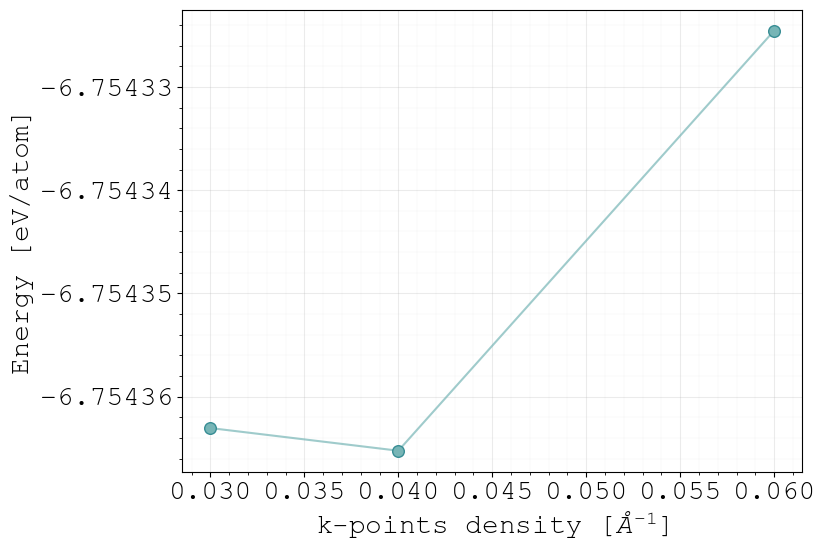

In [113]:
# Plot the kpoints 
fig, ax = plt.subplots(figsize=(8, 6))
ax.ticklabel_format(style='plain')

# Disable scientific and offset notation
formatter = ScalarFormatter(useOffset=False, useMathText=False)
formatter.set_scientific(False)

# Set formatter for both axes
ax.xaxis.set_major_formatter(formatter)
ax.yaxis.set_major_formatter(formatter)

# Plot the k-points data
ax.scatter(kp_dftb_x, kp_dftb_y, label = 'Direct', color = dataset_colors[2], edgecolors 
           = dataset_line_colors[2], s = 70, marker='o', zorder=3)

ax.plot(kp_dftb_x, kp_dftb_y, color = dataset_colors[2], linestyle='-', alpha=0.7, zorder = 2)


# Set the x and y labels
ax.set(xlabel= r"k-points density [$\AA^{-1}$]", ylabel='Energy [eV/atom]')

# Major grid:
ax.grid(True, which='major', linestyle='-', linewidth=0.75, alpha=0.25)

ax.set_axisbelow(True) # <-- Ensure grid is below data

# Minor ticks and grid:
ax.minorticks_on()
ax.grid(True, which='minor', linestyle='-', linewidth=0.25, alpha=0.15)
plt.show()

<div style="text-align: justified; margin-bottom: 20px; font-family: Arial, sans-serif;">
    <p> 
    We need to perform the convergence test for the k-point mesh grid to ensure that our DTF calculations yield accurate results. For this, we use a convergence criterion of 1meV/atom.
    </p>
</div>

In [114]:
# Set new limits 
gap_y = 0.0002
gap_x = 0.002
limit_y_up   = kp_dftb_y[1] + 1e-3/2
limit_y_down = kp_dftb_y[1] - 1e-3/2 
window_x = [kp for kp in kp_dftb_x]
window_x[0] += gap_x
window_x[-1] -= gap_x

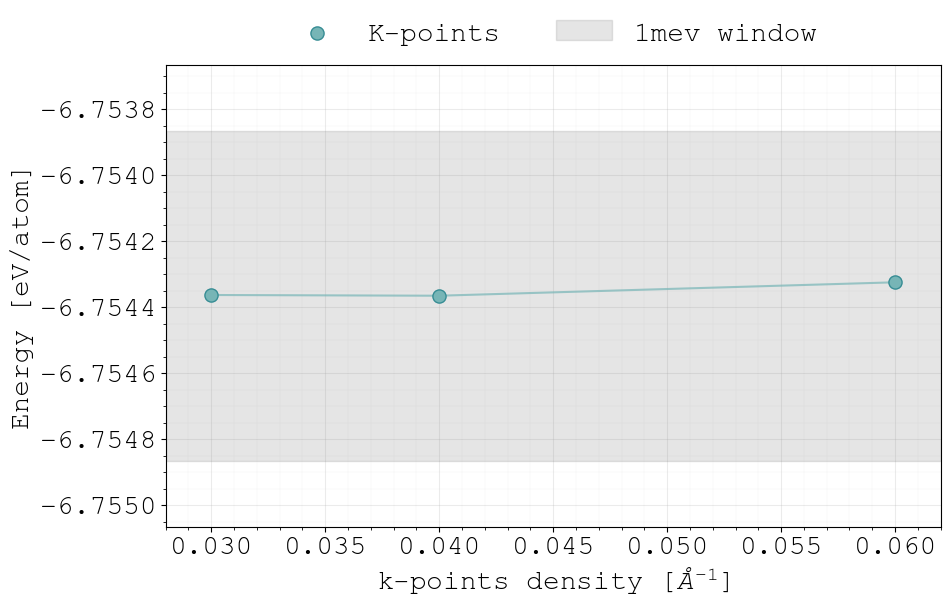

In [115]:
# Plot the kpoints 
fig, ax = plt.subplots(figsize=(10, 6))
ax.ticklabel_format(style='plain')

# Disable scientific and offset notation
formatter = ScalarFormatter(useOffset=False, useMathText=False)
formatter.set_scientific(False)

# Set formatter for both axes
ax.xaxis.set_major_formatter(formatter)
ax.yaxis.set_major_formatter(formatter)

# Plot the k-points data
ax.scatter(kp_dftb_x, kp_dftb_y, label = 'K-points', color = dataset_colors[2], edgecolors 
           = dataset_line_colors[2], s = 90, marker='o', zorder=3)

ax.plot(kp_dftb_x, kp_dftb_y, color = dataset_colors[2], linestyle='-', alpha=0.7, zorder = 2)

# Plot the window
ax.fill_between(window_x, limit_y_down, limit_y_up, color=dataset_colors[1],
                alpha=0.2, zorder=1, label='1mev window')

# Set the x and y labels
ax.set(xlabel = r"k-points density [$\AA^{-1}$]", ylabel='Energy [eV/atom]')

# Set the x and y limits
ax.set_ylim(limit_y_down - gap_y, limit_y_up + gap_y)
ax.set_xlim(min(kp_dftb_x) - gap_x, max(kp_dftb_x) + gap_x)

# Legend settings
handles, labels = ax.get_legend_handles_labels()
desired_order = [0, 1]
ax.legend(
    [handles[i] for i in desired_order],
    [labels[i] for i in desired_order],
    loc='upper center',
    bbox_to_anchor=(0.5, 1.15),  # place legend above the axes, centered
    ncol=4,                      # spread legend entries horizontally
    frameon = False                # remove legend border/frame
)

# Grid settings
ax.grid(True, which='major', linestyle='-', linewidth=0.75, alpha=0.25)
ax.minorticks_on()
ax.grid(True, which='minor', linestyle='-', linewidth=0.25, alpha=0.15)
ax.set_axisbelow(True)
fig.savefig("../tex-file/Figures/dftb-kpoints.png", dpi = 300, transparent = True, bbox_inches='tight')
plt.show()

<div class="header" style="text-align: center; margin-top: 20px; margin-bottom: 20px; font-family: Arial, sans-serif;">
    <h2>Cut-off Energy VASP</h2>
</div>

<div style="text-align: justified; margin-bottom: 20px; font-family: Arial, sans-serif;">
    <p> 
    Now we shall perform the convergence test for the cut-off energy in VASP calculations. The cut-off energy determines the maximum kinetic energy of the plane waves used in the calculations. A higher cut-off energy generally leads to more accurate results, but also increases computational cost. We will use a convergence criterion of 1meV/atom for this test.
    </p>
</div>

In [116]:
# Read cutoff energy data
cutoff_dir = "../dftb/ecut.dat"
cutoff_data = pd.read_csv(cutoff_dir, sep=r'\s+', header=None)

In [117]:
# Prepare the cutoff energy data
cutoff_x = cutoff_data.iloc[:, 0].values
cutoff_y = cutoff_data.iloc[:, 1].values / POSCAR_FILE.n_atoms

In [118]:
ecut_lim_up = cutoff_y[-1] + 1e-3
ecut_lim_down = cutoff_y[-1]
ecut_window = [energy for energy in cutoff_x]
ecut_window[0] -= 50
ecut_window[-1] += 50

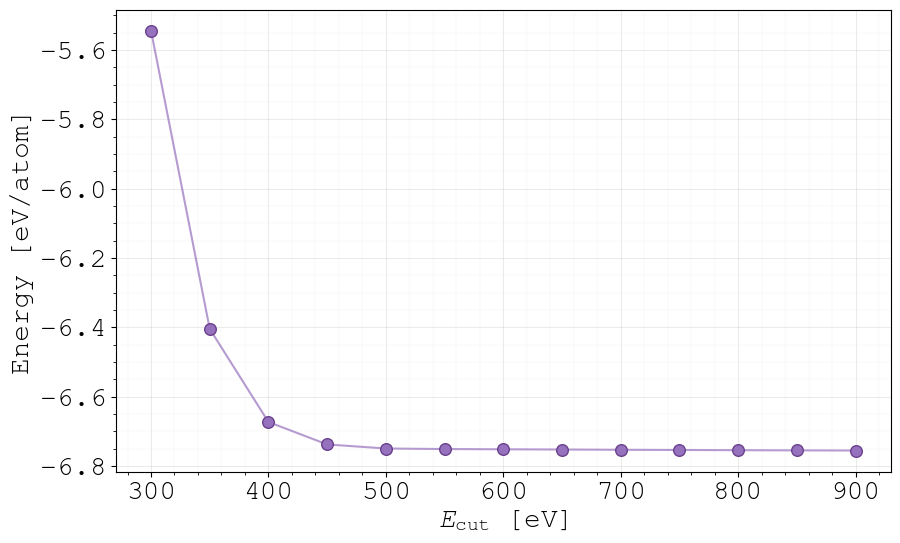

In [119]:
fig, ax = plt.subplots(figsize=(10, 6))

# Plot the cutoff energy data
ax.scatter(cutoff_x, cutoff_y, label='Cutoff energy', color=dataset_colors[0],
           edgecolors=dataset_line_colors[0], s=70, marker='o', zorder=3)
ax.plot(cutoff_x, cutoff_y, color=dataset_colors[0], linestyle='-', alpha=0.7, zorder=2)

# Set the x and y labels
ax.set(xlabel=r"$E_{\text{cut}}$ [eV]", ylabel='Energy [eV/atom]')

# Grid settings
ax.grid(True, which='major', linestyle='-', linewidth=0.75, alpha=0.25)
ax.minorticks_on()
ax.grid(True, which='minor', linestyle='-', linewidth=0.25, alpha=0.15)
ax.set_axisbelow(True)


plt.show()


In [120]:
# Limit settings for the cutoff energy plot
slice = 3
ecut_x_gap = 15
ecut_y_gap = 0.001

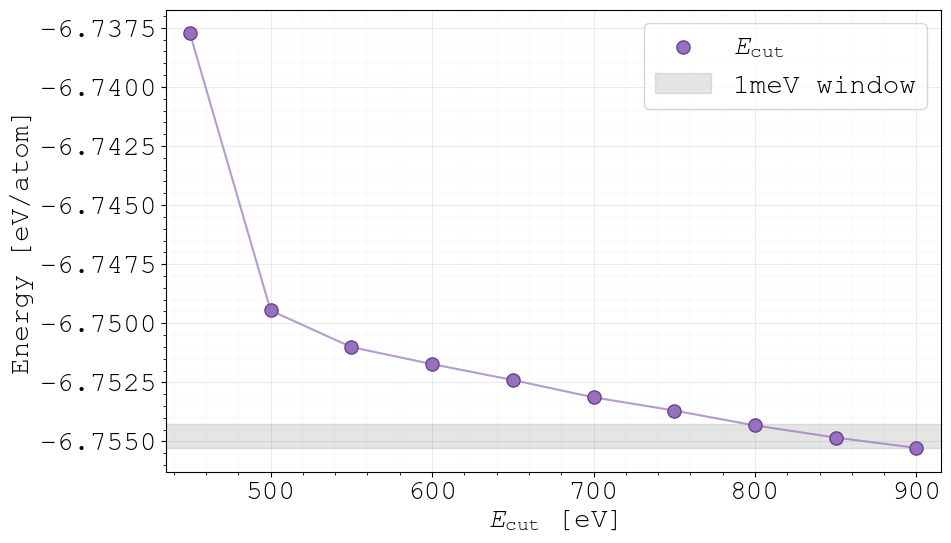

In [121]:
fig, ax = plt.subplots(figsize=(10, 6))
# Plot the cutoff energy data
ax.scatter(cutoff_x[slice:], cutoff_y[slice:], label=r'$E_{\text{cut}}$', color=dataset_colors[0],
           edgecolors=dataset_line_colors[0], s=90, marker='o', zorder=3)
ax.plot(cutoff_x[slice:], cutoff_y[slice:], color=dataset_colors[0], linestyle='-', alpha=0.7, zorder=2)

# Fill the energy window
ax.fill_between(ecut_window, ecut_lim_down, ecut_lim_up, color= dataset_colors[1],
                alpha=0.2, zorder=1, label='1meV window')


# Set the x and y labels
ax.set(xlabel=r"$E_{\text{cut}}$ [eV]", ylabel='Energy [eV/atom]')

# Set the x and y limits
ax.set_ylim(cutoff_y[-1] - ecut_y_gap, cutoff_y[slice] + ecut_y_gap)
ax.set_xlim(cutoff_x[slice] - ecut_x_gap, cutoff_x[-1] + ecut_x_gap)



# Grid settings
ax.grid(True, which='major', linestyle='-', linewidth=0.75, alpha=0.25)
ax.minorticks_on()
ax.grid(True, which='minor', linestyle='-', linewidth=0.25, alpha=0.15)
ax.set_axisbelow(True)

# Legend settings
#plt.legend(loc='upper center', bbox_to_anchor=(0.5, 1.15), ncol=4, frameon=False)
#ax.legend(loc='upper center', bbox_to_anchor=(0.5, 1.15), ncol=4, frameon=True)
ax.legend()
fig.savefig("../tex-file/Figures/cutoff-vasp.png", dpi = 300, transparent = True, bbox_inches='tight')
plt.show()


<div class="header" style="text-align: center; margin-top: 20px; margin-bottom: 20px; font-family: Arial, sans-serif;">
    <h2>K-points VASP</h2>
</div>
<div style="text-align: justified; margin-bottom: 20px; font-family: Arial, sans-serif;">
    <p> 
    Here we perform the same convergence test for the k-point mesh grid in VASP calculations using the same convergence criterion of 1meV/atom.
    </p>
</div>

In [122]:
# Get the k-pints data
kp_vasp_dir = "../cluster-files/kp.dat"
kp_vasp = pd.read_csv(kp_vasp_dir, sep=r'\s+', header = None)

In [123]:
# Prepare the data for plotting
kp_vasp_x = [delta_k[2], delta_k[6], delta_k[8]]
kp_vasp_y = kp_vasp.iloc[:, 1].values / POSCAR_FILE.n_atoms

In [124]:
# Set new limits 
gap_kp_vasp_y = 0.0002
gap_kp_vasp_x = 0.002
limit_kp_vasp_up   = kp_vasp_y[1] + 1e-3/2
limit_kp_vasp_down = kp_vasp_y[1] - 1e-3/2 
window_kp_vasp_x = [kp for kp in kp_vasp_x]
window_kp_vasp_x[0] += gap_kp_vasp_x
window_kp_vasp_x[-1] -= gap_kp_vasp_x   

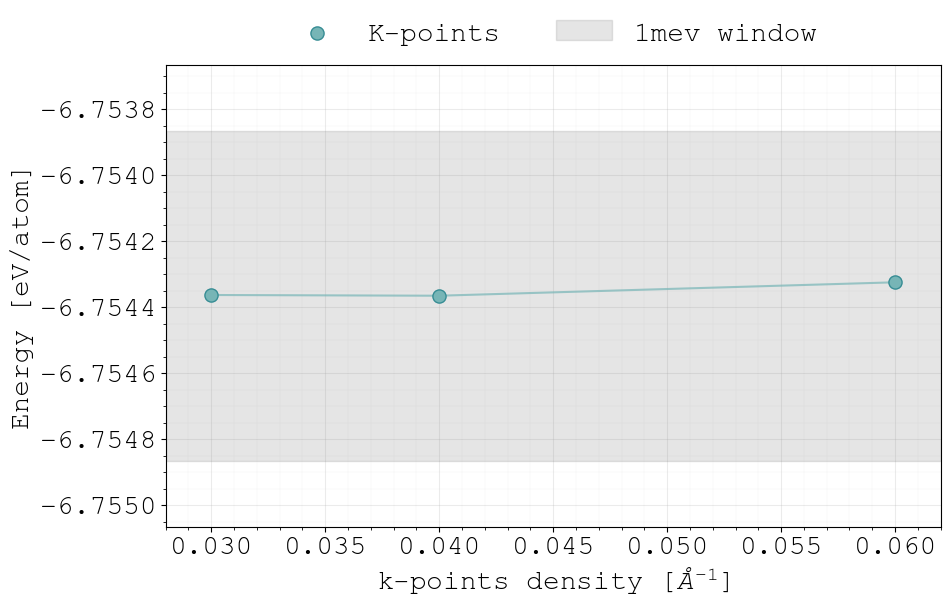

In [125]:
# Plot the kpoints 
fig, ax = plt.subplots(figsize=(10, 6))
ax.ticklabel_format(style='plain')

# Disable scientific and offset notation
formatter = ScalarFormatter(useOffset=False, useMathText=False)
formatter.set_scientific(False)

# Set formatter for both axes
ax.xaxis.set_major_formatter(formatter)
ax.yaxis.set_major_formatter(formatter)

# Plot the k-points data
ax.scatter(kp_vasp_x, kp_vasp_y, label = 'K-points', color = dataset_colors[2], edgecolors 
           = dataset_line_colors[2], s = 90, marker='o', zorder=3)

ax.plot(kp_vasp_x, kp_vasp_y, color = dataset_colors[2], linestyle='-', alpha=0.7, zorder = 2)

# Plot the window
ax.fill_between(window_x, limit_kp_vasp_down, limit_kp_vasp_up, color=dataset_colors[1],
                alpha=0.2, zorder=1, label='1mev window')

# Set the x and y labels
ax.set(xlabel = r"k-points density [$\AA^{-1}$]", ylabel='Energy [eV/atom]')

# Set the x and y limits
ax.set_ylim(limit_kp_vasp_down - gap_kp_vasp_y, limit_kp_vasp_up + gap_kp_vasp_y)
ax.set_xlim(min(kp_vasp_x) - gap_kp_vasp_x, max(kp_vasp_x) + gap_kp_vasp_x)

# Legend settings
handles, labels = ax.get_legend_handles_labels()
desired_order = [0, 1]
ax.legend(
    [handles[i] for i in desired_order],
    [labels[i] for i in desired_order],
    loc='upper center',
    bbox_to_anchor=(0.5, 1.15),  # place legend above the axes, centered
    ncol=4,                      # spread legend entries horizontally
    frameon = False                # remove legend border/frame
)

# Grid settings
ax.grid(True, which='major', linestyle='-', linewidth=0.75, alpha=0.25)
ax.minorticks_on()
ax.grid(True, which='minor', linestyle='-', linewidth=0.25, alpha=0.15)
ax.set_axisbelow(True)
fig.savefig("../tex-file/Figures/kpoints-vasp.png", dpi = 300, transparent = True, bbox_inches='tight')
plt.show()

<div class="header" style="text-align: center; margin-top: 20px; margin-bottom: 20px; font-family: Arial, sans-serif;">
    <h2>Partial Density of States (PDOS) & Density of States (DOS)</h2>
</div>
<div style="text-align: justified; margin-bottom: 20px; font-family: Arial, sans-serif;">
    <p> 
    After performing the corresponding convergence tests, we proceed to relax the CSH structure and calculate the Partial Density of States (PDOS).
    The structure was relaxed using VASP with a cut-off energy of 800 eV and a k-point mesh grid of 1x1x1---which is the gamma point only---and the PBE functional. The PDOS was calculated using the same parameters.
    </p>
</div>

<div class="header" style="text-align: center; margin-top: 20px; margin-bottom: 20px; font-family: Arial, sans-serif;">
    <h2>MLFF Training Phase Analysis</h2>
</div>
<div style="text-align: justified; margin-bottom: 20px; font-family: Arial, sans-serif;">
    <p> 
    In this section, we analyse the training phase of the Machine Learning Force Field (MLFF) model. This MLFF model was trained through a Molecular Dynamics (MD) simulation of the relaxed CSH structure. This simulation was carried out using VASP for a total of 50000 steps, with a time step of 2 fs, and a temperature of 400 K. 
    </p>
</div>

In [126]:
# training files directory
train_400K_dir = "../cluster-files/ml-400k/training/"

<div class="header" style="text-align: center; margin-top: 20px; margin-bottom: 20px; font-family: Arial, sans-serif;">
    <h3>Volume</h3>
</div>

In [127]:
# Read volume data
volume_training_dat = pd.read_csv(train_400K_dir + "volume.dat", sep=r'\s+', header=None)

# Time vector 
time = 2 / 1e3 * np.arange(0, 50000, 1) # in picoseconds

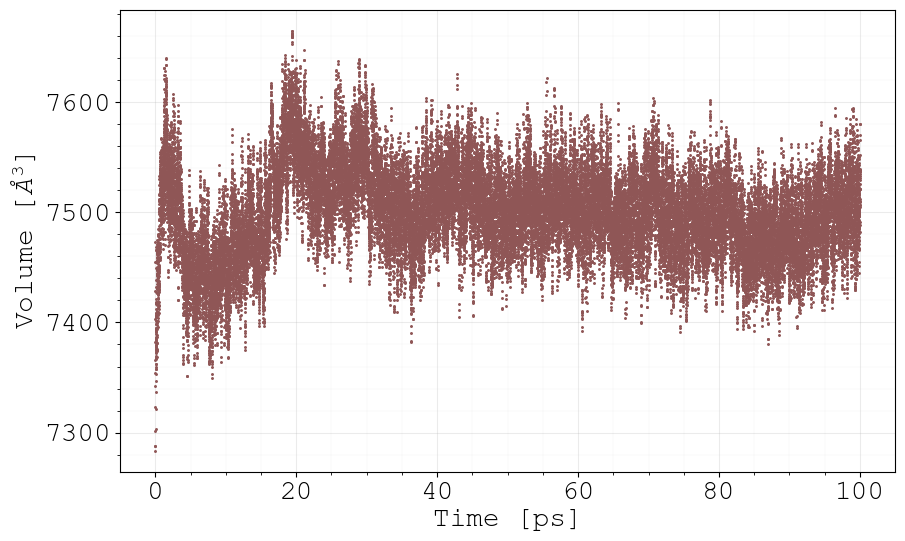

In [128]:
fig, ax = plt.subplots(figsize=(10, 6))

# Plot the volume data
plt.scatter(time, volume_training_dat.iloc[:, 0].values, label='Volume', color=dataset_colors[3],
            edgecolors=dataset_line_colors[3] ,s=5, marker='.', zorder=3)

# Set labels
ax.set(xlabel='Time [ps]', ylabel=r'Volume [$\AA^3$]')

# Grid settings
ax.grid(True, which='major', linestyle='-', linewidth=0.75, alpha=0.25)
ax.minorticks_on()
ax.grid(True, which='minor', linestyle='-', linewidth=0.25, alpha=0.15)
ax.set_axisbelow(True)

# Set legend
#ax.legend()

plt.show()

<div class="header" style="text-align: center; margin-top: 20px; margin-bottom: 20px; font-family: Arial, sans-serif;">
    <h3>Total Energy</h3>
</div>

In [129]:
# Read total energy data
toten_training_dat = pd.read_csv(train_400K_dir + "entot.dat", sep=r'\s+', header=None)

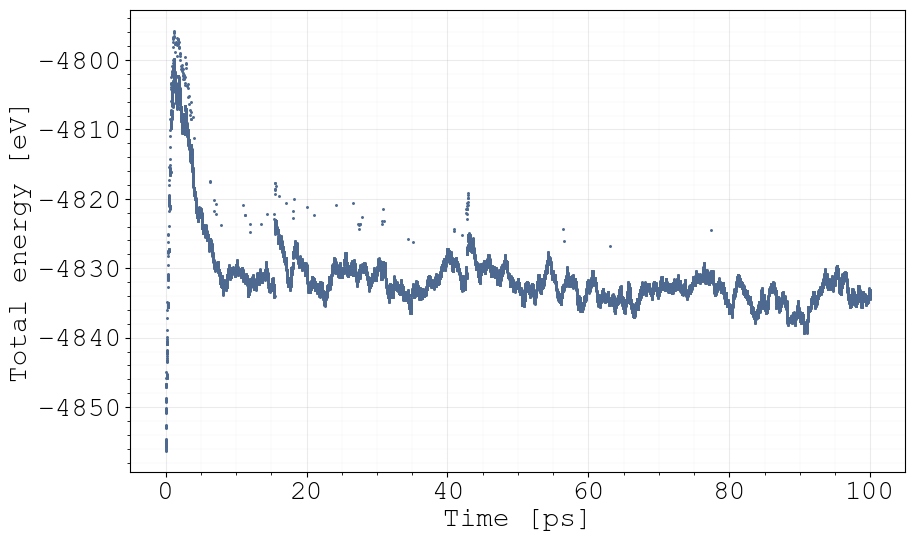

In [130]:
fig, ax = plt.subplots(figsize=(10, 6))

# Plot the volume data
plt.scatter(time, toten_training_dat.iloc[:, 0].values, label='Volume', color = dataset_colors[4],
            edgecolors=dataset_line_colors[4] ,s=5, marker='.', zorder=3)

# Set labels
ax.set(xlabel='Time [ps]', ylabel=r'Total energy [eV]')

# Grid settings
ax.grid(True, which='major', linestyle='-', linewidth=0.75, alpha=0.25)
ax.minorticks_on()
ax.grid(True, which='minor', linestyle='-', linewidth=0.25, alpha=0.15)
ax.set_axisbelow(True)

# Set legend
#ax.legend()

plt.show()

<div class="header" style="text-align: center; margin-top: 20px; margin-bottom: 20px; font-family: Arial, sans-serif;">
    <h3>
    BEEF - Bayesian Error Estimation Functional
    </h3>
</div>

In [131]:
# Get the BEEF data
beef_dat = pd.read_csv(train_400K_dir + "beef.dat", sep=r'\s+', header=None)

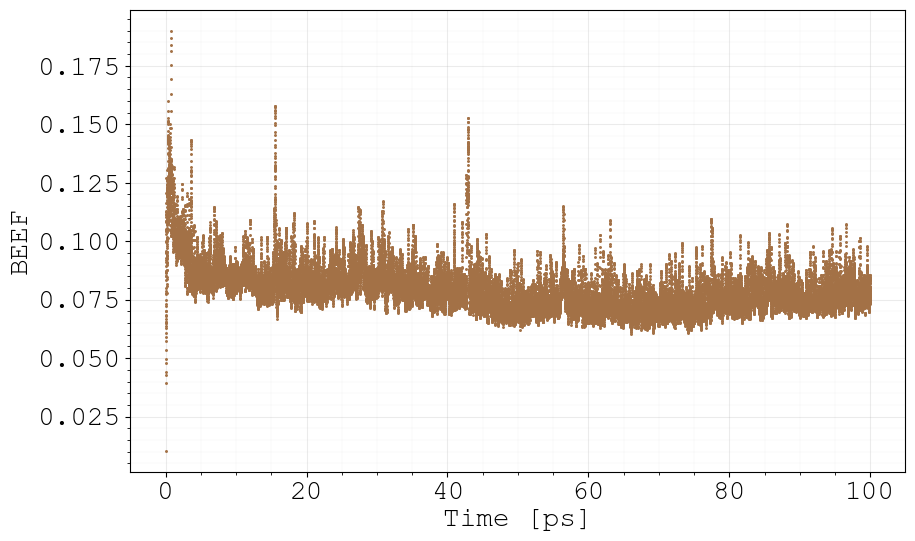

In [132]:
fig, ax = plt.subplots(figsize=(10, 6))

# Plot the volume data
plt.scatter(time, beef_dat.iloc[:, 1].values, label='Volume', color = dataset_colors[5],
            edgecolors=dataset_line_colors[5] ,s=5, marker='.', zorder=3)

# Set labels
ax.set(xlabel='Time [ps]', ylabel=r'BEEF')

# Grid settings
ax.grid(True, which='major', linestyle='-', linewidth=0.75, alpha=0.25)
ax.minorticks_on()
ax.grid(True, which='minor', linestyle='-', linewidth=0.25, alpha=0.15)
ax.set_axisbelow(True)

# Set legend
#ax.legend()

plt.show()

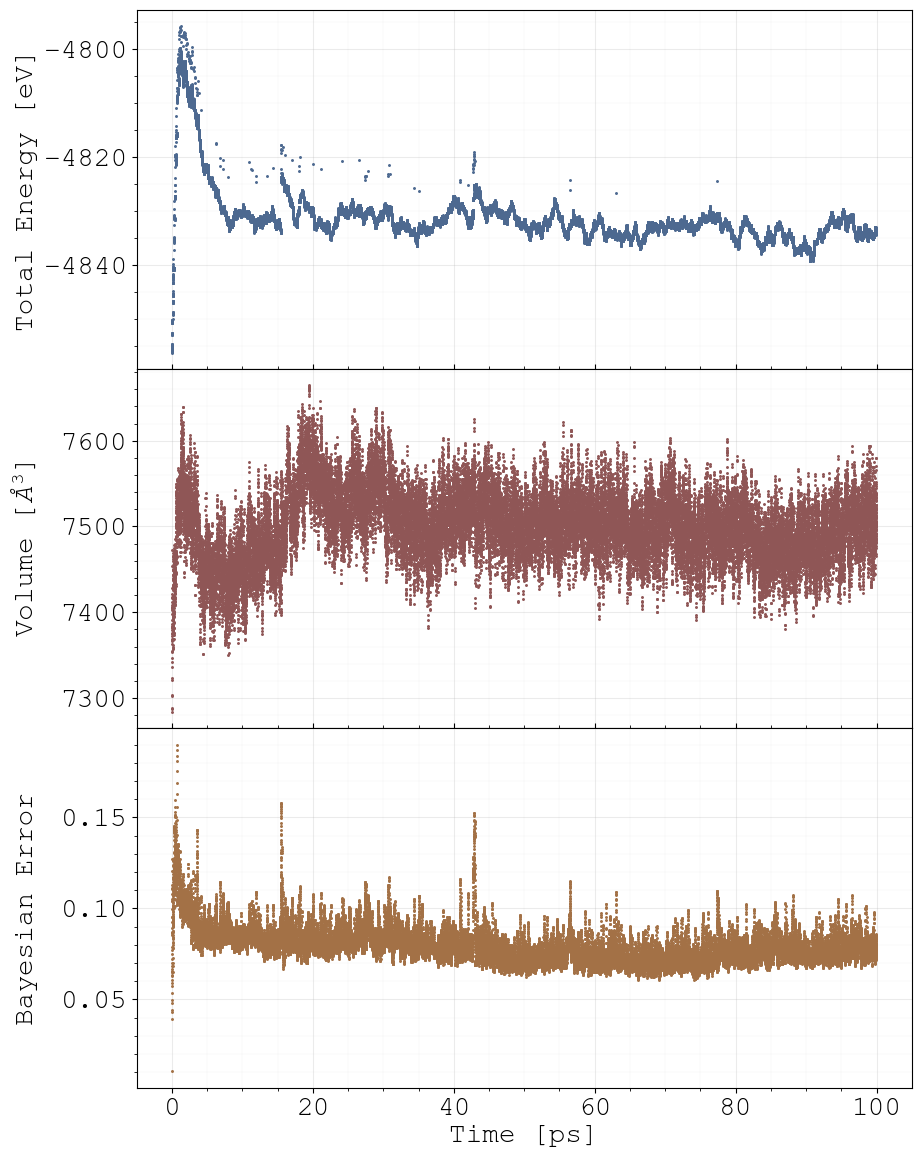

In [133]:
import matplotlib.pyplot as plt

# Create subplots sharing the x-axis
fig, axs = plt.subplots(nrows=3, ncols=1, figsize=(10, 14), sharex=True)

# --- First subplot: Energy Error ---
axs[0].scatter(time, toten_training_dat.iloc[:, 0].values, label='Volume', color = dataset_colors[4],
            edgecolors=dataset_line_colors[4] ,s=5, marker='.', zorder=3
            )

axs[0].set_ylabel(r'Total Energy [eV]')
axs[0].grid(True, which='major', linestyle='-', linewidth=0.75, alpha=0.25)
axs[0].minorticks_on()
axs[0].grid(True, which='minor', linestyle='-', linewidth=0.25, alpha=0.15)
axs[0].set_axisbelow(True)

# --- Second subplot: Force RMSE ---
axs[1].scatter(time, volume_training_dat.iloc[:, 0].values, label='Volume', color=dataset_colors[3],
            edgecolors=dataset_line_colors[3] ,s=5, marker='.', zorder=3)

axs[1].set_ylabel(r'Volume [$\AA^3$]')
axs[1].grid(True, which='major', linestyle='-', linewidth=0.75, alpha=0.25)
axs[1].minorticks_on()
axs[1].grid(True, which='minor', linestyle='-', linewidth=0.25, alpha=0.15)
axs[1].set_axisbelow(True)

# --- Third subplot: Stress RMSE ---
axs[2].scatter(time, beef_dat.iloc[:, 1].values, label='Volume', color = dataset_colors[5],
            edgecolors=dataset_line_colors[5] ,s=5, marker='.', zorder=3)

axs[2].set_ylabel(r'Bayesian Error')
axs[2].set_xlabel('Time [ps]')
axs[2].grid(True, which='major', linestyle='-', linewidth=0.75, alpha=0.25)
axs[2].minorticks_on()
axs[2].grid(True, which='minor', linestyle='-', linewidth=0.25, alpha=0.15)
axs[2].set_axisbelow(True)

# Align layout
fig.align_ylabels(axs)
#plt.tight_layout()
plt.subplots_adjust(hspace=0.0)  # Reduce vertical space to make them feel joined
for ax in axs[1:]:
    ax.xaxis.set_tick_params(which='both', bottom=True, top=True)
fig.savefig("../tex-file/Figures/training-stats.png", dpi = 300, transparent = True, bbox_inches='tight')
plt.show()

<div class="header" style="text-align: center; margin-top: 20px; margin-bottom: 20px; font-family: Arial, sans-serif;">
    <h2>MLFF Prediction Phase Analysis</h2>
</div>
<div style="text-align: justified; margin-bottom: 20px; font-family: Arial, sans-serif;">
    <p> 
    Subsequent to the training phase, we proceed to the prediction phase using the MLFF model. For this, we use the file `ML_FFN` generated during the training phase. The prediction phase involves a MD simulation for a total of 50000 steps. During this simulation, we monitor the volume, total energy and themperature of the system. 
    </p>
</div>

In [134]:
# Prediction files directory
pred_400K_dir = "../cluster-files/ml-400k/prediction/"

<div class="header" style="text-align: center; margin-top: 20px; margin-bottom: 20px; font-family: Arial, sans-serif;">
    <h3>Volume</h3>
</div>

In [135]:
# Read volume data
volume_pred_dat = pd.read_csv(pred_400K_dir + "volume.dat", sep=r'\s+', header=None)
volume_pred_dat.shape[0]

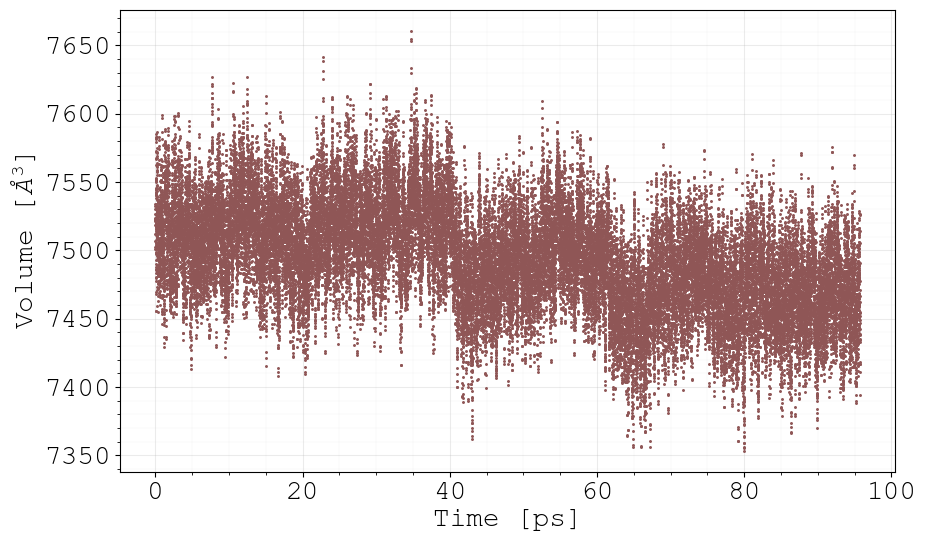

In [136]:
fig, ax = plt.subplots(figsize=(10, 6))

# Plot the volume data
plt.scatter(time[:volume_pred_dat.shape[0]], volume_pred_dat.iloc[:, 0].values, label='Volume', color=dataset_colors[3],
            edgecolors=dataset_line_colors[3] ,s=5, marker='.', zorder=3)

# Set labels
ax.set(xlabel='Time [ps]', ylabel=r'Volume [$\AA^3$]')

# Grid settings
ax.grid(True, which='major', linestyle='-', linewidth=0.75, alpha=0.25)
ax.minorticks_on()
ax.grid(True, which='minor', linestyle='-', linewidth=0.25, alpha=0.15)
ax.set_axisbelow(True)

# Set legend
#ax.legend()

plt.show()

<div class="header" style="text-align: center; margin-top: 20px; margin-bottom: 20px; font-family: Arial, sans-serif;">
    <h3>Total Energy</h3>
</div>

In [137]:
# Read total energy data
toten_pred_dat = pd.read_csv(pred_400K_dir + "entot.dat", sep=r'\s+', header=None)

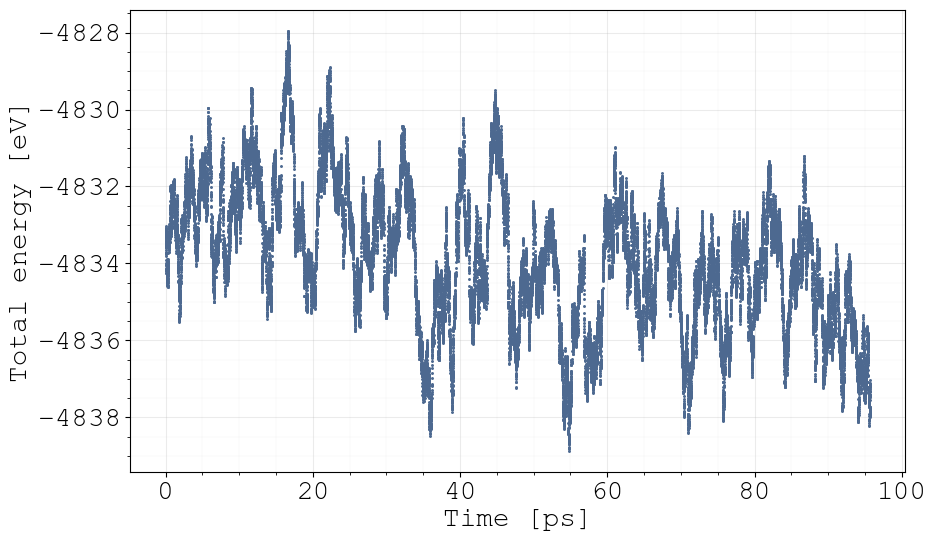

In [138]:
fig, ax = plt.subplots(figsize=(10, 6))

# Plot the volume data
plt.scatter(time[:volume_pred_dat.shape[0]], toten_pred_dat.iloc[:, 0].values, label = 'Total Energy', color = dataset_colors[4],
            edgecolors=dataset_line_colors[4] ,s=5, marker='.', zorder=3)

# Set labels
ax.set(xlabel='Time [ps]', ylabel=r'Total energy [eV]')

# Grid settings
ax.grid(True, which='major', linestyle='-', linewidth=0.75, alpha=0.25)
ax.minorticks_on()
ax.grid(True, which='minor', linestyle='-', linewidth=0.25, alpha=0.15)
ax.set_axisbelow(True)

plt.show()

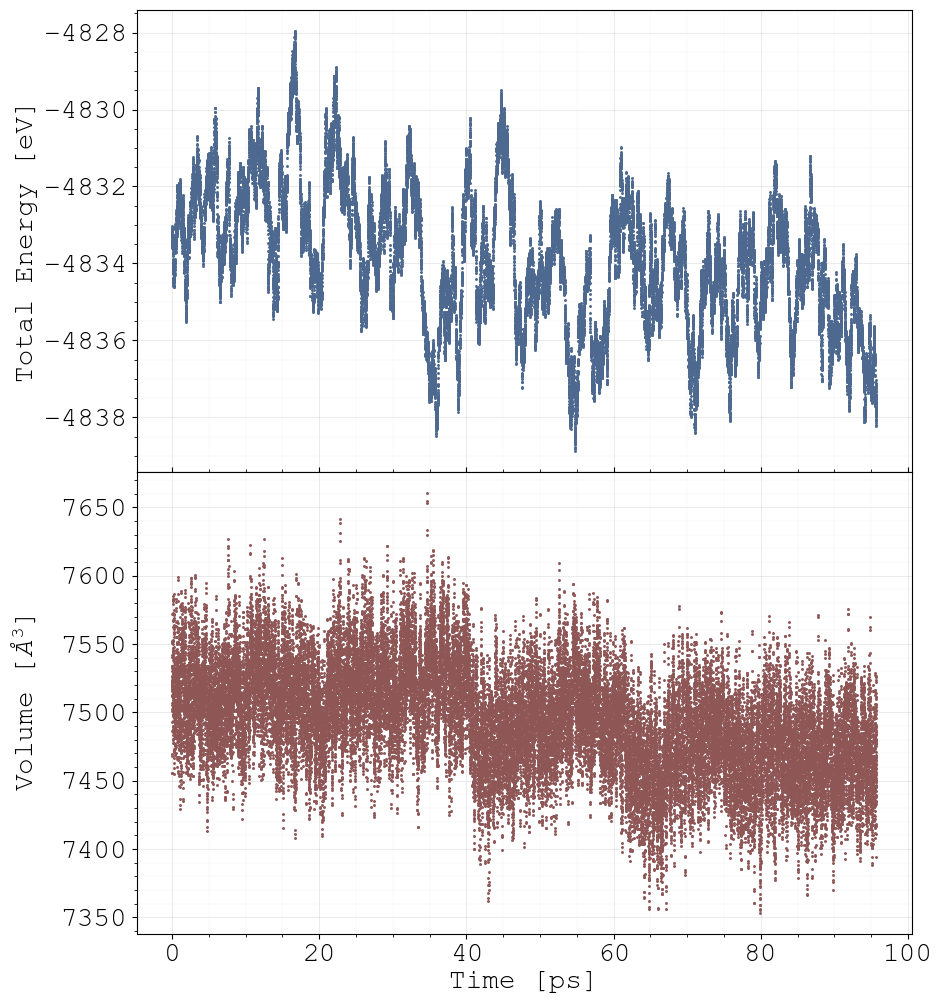

In [139]:
# Create subplots sharing the x-axis
fig, axs = plt.subplots(nrows=2, ncols=1, figsize=(10, 12), sharex=True)

# --- First subplot: Energy Error ---
axs[0].scatter(time[:volume_pred_dat.shape[0]], toten_pred_dat.iloc[:, 0].values, label = 'Total Energy', color = dataset_colors[4],
            edgecolors=dataset_line_colors[4] ,s=5, marker='.', zorder=3)

axs[0].set_ylabel(r'Total Energy [eV]')
axs[0].grid(True, which='major', linestyle='-', linewidth=0.75, alpha=0.25)
axs[0].minorticks_on()
axs[0].grid(True, which='minor', linestyle='-', linewidth=0.25, alpha=0.15)
axs[0].set_axisbelow(True)


# --- Second subplot: Force RMSE ---
axs[1].scatter(time[:volume_pred_dat.shape[0]], volume_pred_dat.iloc[:, 0].values, label='Volume', color=dataset_colors[3],
            edgecolors=dataset_line_colors[3] ,s=5, marker='.', zorder=3
            )

axs[1].set_ylabel(r'Volume [$\AA^3$]')
axs[1].set_xlabel('Time [ps]')
axs[1].grid(True, which='major', linestyle='-', linewidth=0.75, alpha=0.25)
axs[1].minorticks_on()
axs[1].grid(True, which='minor', linestyle='-', linewidth=0.25, alpha=0.15)
axs[1].set_axisbelow(True)


# Align layout
fig.align_ylabels(axs)
#plt.tight_layout()
plt.subplots_adjust(hspace=0.0)  # Reduce vertical space to make them feel joined
for ax in axs[1:]:
    ax.xaxis.set_tick_params(which='both', bottom=True, top=True)
fig.savefig("../tex-file/Figures/pred-stats.png", dpi = 300, transparent = True, bbox_inches='tight')
plt.show()

In [140]:
# Get the mean energy value 
mean_energy = toten_pred_dat.iloc[:, 0].mean()

# Get the mean volume value
mean_volume = volume_pred_dat.iloc[:, 0].mean()

print(f"Mean Energy: {mean_energy:.6f} eV")
print(f"Mean Volume: {mean_volume:.6f} Å³")

Mean Energy: -4833.896401 eV
Mean Volume: 7494.106317 Å³


<div class="header" style="text-align: center; margin-top: 20px; margin-bottom: 20px; font-family: Arial, sans-serif;">
    <h2>
    RMSE Energy, Force and Stress Analysis
    </h2>
</div>
<div style="text-align: justified; margin-bottom: 20px; font-family: Arial, sans-serif;">
    <p> 
    This section is devoted to the analysis of the Root Mean Square Error (RMSE) of the energy, force and stress of the MLFF model. The RMSE is a measure of the difference between values predicted by the model and values computed from first principles. For this analysis, we chose 50 structures from the `XDATCAR' file generated during the prediction phase.  
    </p>
</div>

In [141]:
# Error data directory
error_dir = "../cluster-files/ml-400k/error/"

<div class="header" style="text-align: center; margin-top: 20px; margin-bottom: 20px; font-family: Arial, sans-serif;">
    <h3>Total Energy</h3>
</div>

In [142]:
# Get the error data
dft_energy_error = pd.read_csv(error_dir + "dft_data/dft_toten.dat", sep=r'\s+', header=None)
mlff_energy_error = pd.read_csv(error_dir + "ml_data/ml_toten.dat", sep=r'\s+', header=None)

In [143]:
# Compute the energy error per atom 
EnergyError = (mlff_energy_error.iloc[:, 1].values - dft_energy_error.iloc[:, 1].values) / POSCAR_FILE.n_atoms

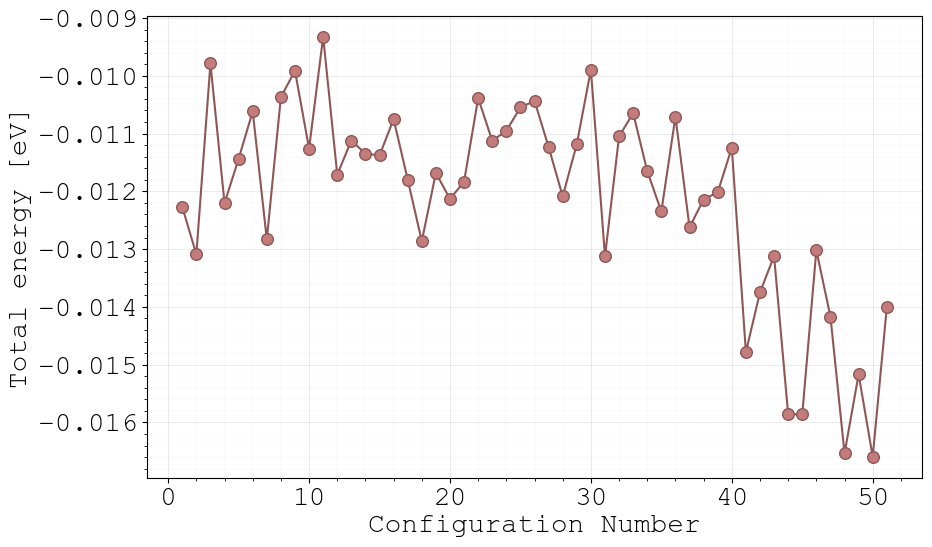

In [144]:
fig, ax = plt.subplots(figsize=(10, 6))

# Plot the volume data
ax.scatter(mlff_energy_error.iloc[:, 0].values, EnergyError, label='Energy error', color=dataset_colors[3],
            edgecolors=dataset_line_colors[3], s=70, marker='o', zorder=3)

ax.plot(mlff_energy_error.iloc[:, 0].values, EnergyError, label='Energy error', color = dataset_line_colors[3],
        linewidth=1.5, zorder=1)

# Set labels
ax.set(xlabel='Configuration Number', ylabel=r'Total energy [eV]')

# Grid settings
ax.grid(True, which='major', linestyle='-', linewidth=0.75, alpha=0.25)
ax.minorticks_on()
ax.grid(True, which='minor', linestyle='-', linewidth=0.25, alpha=0.15)
ax.set_axisbelow(True)

plt.show()

<div class="header" style="text-align: center; margin-top: 20px; margin-bottom: 20px; font-family: Arial, sans-serif;">
    <h3>RMSE Force</h3>
</div>

In [145]:
# Get force rmse data
ForceRMSE = pd.read_csv(error_dir + "ml_rmse_force.dat",  sep=r'\s+')

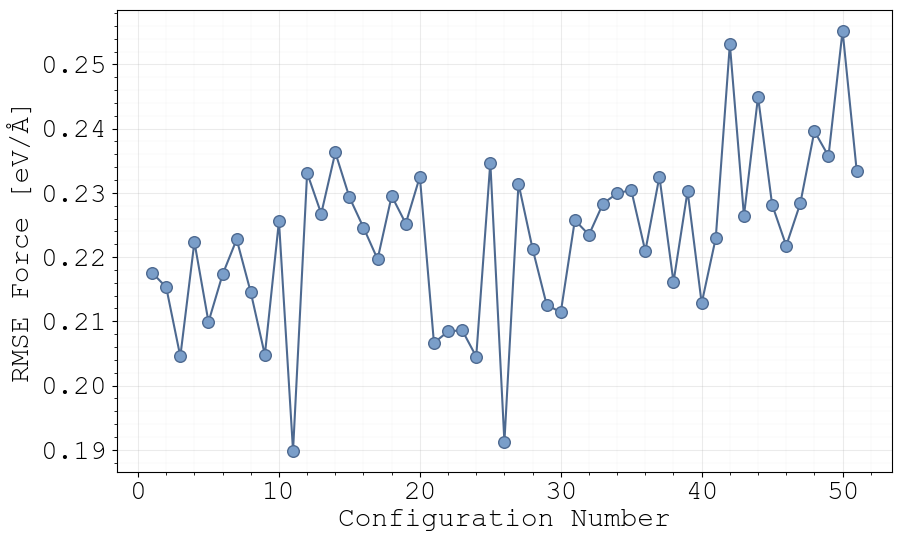

In [146]:
fig, ax = plt.subplots(figsize=(10, 6))

# Plot the volume data
ax.scatter(ForceRMSE['Structure'].values, ForceRMSE['RMSE'].values, label='RMSE Force', color=dataset_colors[4],
            edgecolors=dataset_line_colors[4], s=70, marker='o', zorder=3)

ax.plot(ForceRMSE['Structure'].values, ForceRMSE['RMSE'], label='RMSE Force', color = dataset_line_colors[4],
        linewidth=1.5, zorder=1)

# Set labels
ax.set(xlabel='Configuration Number', ylabel=r'RMSE Force [eV/Å]')

# Grid settings
ax.grid(True, which='major', linestyle='-', linewidth=0.75, alpha=0.25)
ax.minorticks_on()
ax.grid(True, which='minor', linestyle='-', linewidth=0.25, alpha=0.15)
ax.set_axisbelow(True)

plt.show()

<div class="header" style="text-align: center; margin-top: 20px; margin-bottom: 20px; font-family: Arial, sans-serif;">
    <h3>RMSE Stress</h3>
</div>

In [147]:
# Get force rmse data
StressRMSE = pd.read_csv(error_dir + "rmse_stress.dat",  sep=r'\s+')

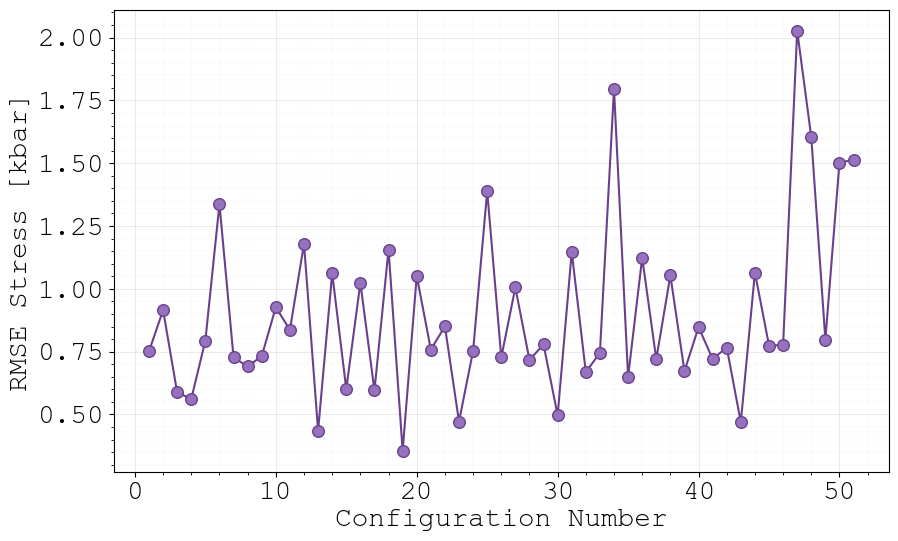

In [148]:
fig, ax = plt.subplots(figsize=(10, 6))

# Plot the volume data
ax.scatter(range(1, 52), StressRMSE['RMSE_Stress'].values, label='RMSE Stress', color=dataset_colors[0],
            edgecolors=dataset_line_colors[0], s=70, marker='o', zorder=3)

ax.plot(range(1, 52), StressRMSE['RMSE_Stress'].values, label='RMSE Stress', color = dataset_line_colors[0],
        linewidth=1.5, zorder=1)

# Set labels
ax.set(xlabel='Configuration Number', ylabel=r'RMSE Stress [kbar]')

# Grid settings
ax.grid(True, which='major', linestyle='-', linewidth=0.75, alpha=0.25)
ax.minorticks_on()
ax.grid(True, which='minor', linestyle='-', linewidth=0.25, alpha=0.15)
ax.set_axisbelow(True)

plt.show()

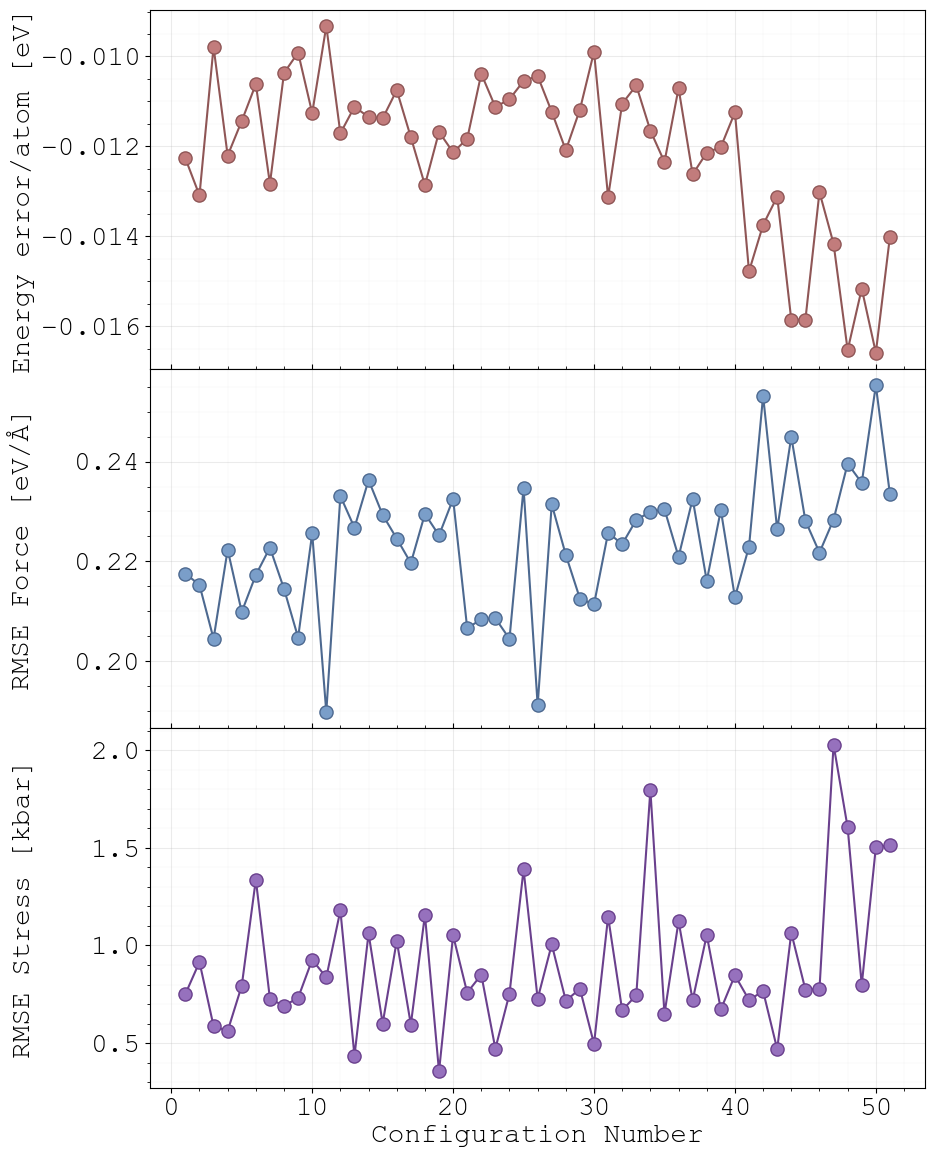

In [149]:
import matplotlib.pyplot as plt

# Create subplots sharing the x-axis
fig, axs = plt.subplots(nrows=3, ncols=1, figsize=(10, 14), sharex=True)

# --- First subplot: Energy Error ---
axs[0].scatter(mlff_energy_error.iloc[:, 0].values, EnergyError, 
               color=dataset_colors[3], edgecolors=dataset_line_colors[3],
               s=90, marker='o', zorder=3)
axs[0].plot(mlff_energy_error.iloc[:, 0].values, EnergyError, 
            color=dataset_line_colors[3], linewidth=1.5, zorder=1)
axs[0].set_ylabel(r'Energy error/atom [eV]')
axs[0].grid(True, which='major', linestyle='-', linewidth=0.75, alpha=0.25)
axs[0].minorticks_on()
axs[0].grid(True, which='minor', linestyle='-', linewidth=0.25, alpha=0.15)
axs[0].set_axisbelow(True)

# --- Second subplot: Force RMSE ---
axs[1].scatter(ForceRMSE['Structure'].values, ForceRMSE['RMSE'].values, 
               color=dataset_colors[4], edgecolors=dataset_line_colors[4],
               s=90, marker='o', zorder=3)
axs[1].plot(ForceRMSE['Structure'].values, ForceRMSE['RMSE'], 
            color=dataset_line_colors[4], linewidth=1.5, zorder=1)
axs[1].set_ylabel(r'RMSE Force [eV/Å]')
axs[1].grid(True, which='major', linestyle='-', linewidth=0.75, alpha=0.25)
axs[1].minorticks_on()
axs[1].grid(True, which='minor', linestyle='-', linewidth=0.25, alpha=0.15)
axs[1].set_axisbelow(True)

# --- Third subplot: Stress RMSE ---
axs[2].scatter(range(1, 52), StressRMSE['RMSE_Stress'].values, 
               color=dataset_colors[0], edgecolors=dataset_line_colors[0],
               s=90, marker='o', zorder=3)
axs[2].plot(range(1, 52), StressRMSE['RMSE_Stress'].values, 
            color=dataset_line_colors[0], linewidth=1.5, zorder=1)
axs[2].set_ylabel(r'RMSE Stress [kbar]')
axs[2].set_xlabel('Configuration Number')
axs[2].grid(True, which='major', linestyle='-', linewidth=0.75, alpha=0.25)
axs[2].minorticks_on()
axs[2].grid(True, which='minor', linestyle='-', linewidth=0.25, alpha=0.15)
axs[2].set_axisbelow(True)

# Align layout
fig.align_ylabels(axs)
#plt.tight_layout()
plt.subplots_adjust(hspace=0.0)  # Reduce vertical space to make them feel joined
for ax in axs[1:]:
    ax.xaxis.set_tick_params(which='both', bottom=True, top=True)
fig.savefig("../tex-file/Figures/pred-errors.png", dpi = 300, transparent = True, bbox_inches='tight')
plt.show()

In [150]:
# Get the mean energy error, force rmse, and stress rmse values
mean_energy_error = EnergyError.mean()
mean_force_rmse = ForceRMSE['RMSE'].mean()
mean_stress_rmse = StressRMSE['RMSE_Stress'].mean()

print(f"Mean Energy Error: {mean_energy_error:.6f} eV/atom")
print(f"Mean Force RMSE: {mean_force_rmse:.6f} eV/Å")
print(f"Mean Stress RMSE: {mean_stress_rmse:.6f} kbar")

Mean Energy Error: -0.012117 eV/atom
Mean Force RMSE: 0.222992 eV/Å
Mean Stress RMSE: 0.896285 kbar


<div class="header" style="text-align: center; margin-top: 20px; margin-bottom: 20px; font-family: Arial, sans-serif;">
    <h3>
    Errors after refiting the MLFF model
    </h3>
</div>

In [151]:
mlff_rf_energy_error = pd.read_csv(error_dir + "ml_rf_data/ml_rf_toten.dat", sep=r'\s+', header=None)

In [152]:
# Compute the energy error per atom 
rfEnergyError = (mlff_rf_energy_error.iloc[:, 1].values - dft_energy_error.iloc[:, 1].values) / POSCAR_FILE.n_atoms

In [153]:
# Get force rmse data
rfForceRMSE = pd.read_csv(error_dir + "ml_rf_rmse_force.dat",  sep=r'\s+')

# Get strezs rmse data
rfStressRMSE = pd.read_csv(error_dir + "rmse_rf_stress.dat",  sep=r'\s+')

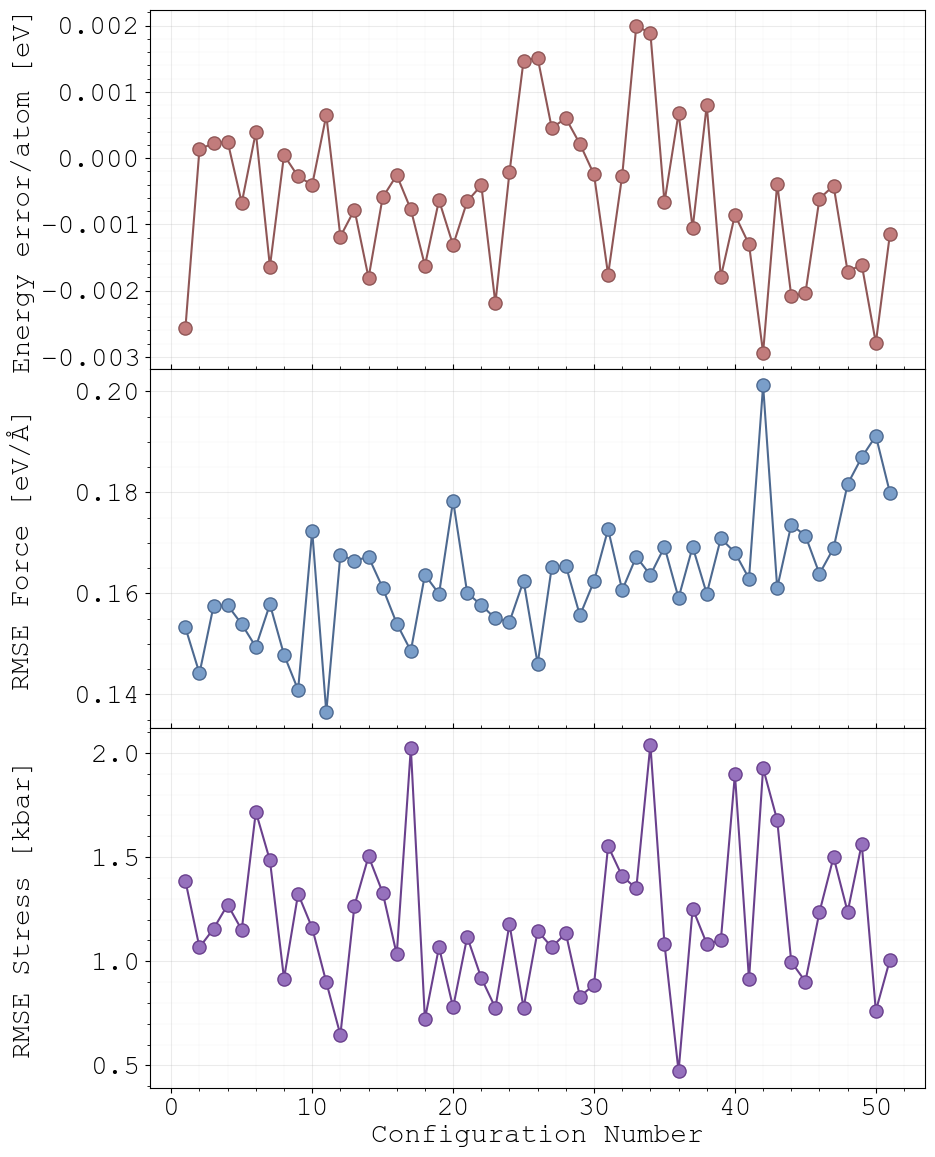

In [154]:
import matplotlib.pyplot as plt

# Create subplots sharing the x-axis
fig, axs = plt.subplots(nrows=3, ncols=1, figsize=(10, 14), sharex=True)

# --- First subplot: Energy Error ---
axs[0].scatter(mlff_rf_energy_error.iloc[:, 0].values, rfEnergyError, 
               color=dataset_colors[3], edgecolors=dataset_line_colors[3],
               s=90, marker='o', zorder=3)
axs[0].plot(mlff_rf_energy_error.iloc[:, 0].values, rfEnergyError, 
            color=dataset_line_colors[3], linewidth=1.5, zorder=1)
axs[0].set_ylabel(r'Energy error/atom [eV]')
axs[0].grid(True, which='major', linestyle='-', linewidth=0.75, alpha=0.25)
axs[0].minorticks_on()
axs[0].grid(True, which='minor', linestyle='-', linewidth=0.25, alpha=0.15)
axs[0].set_axisbelow(True)

# --- Second subplot: Force RMSE ---
axs[1].scatter(rfForceRMSE['Structure'].values, rfForceRMSE['RMSE'].values, 
               color=dataset_colors[4], edgecolors=dataset_line_colors[4],
               s=90, marker='o', zorder=3)
axs[1].plot(rfForceRMSE['Structure'].values, rfForceRMSE['RMSE'], 
            color=dataset_line_colors[4], linewidth=1.5, zorder=1)
axs[1].set_ylabel(r'RMSE Force [eV/Å]')
axs[1].grid(True, which='major', linestyle='-', linewidth=0.75, alpha=0.25)
axs[1].minorticks_on()
axs[1].grid(True, which='minor', linestyle='-', linewidth=0.25, alpha=0.15)
axs[1].set_axisbelow(True)

# --- Third subplot: Stress RMSE ---
axs[2].scatter(range(1, 52), rfStressRMSE['RMSE_Stress'].values, 
               color=dataset_colors[0], edgecolors=dataset_line_colors[0],
               s=90, marker='o', zorder=3)
axs[2].plot(range(1, 52), rfStressRMSE['RMSE_Stress'].values, 
            color=dataset_line_colors[0], linewidth=1.5, zorder=1)
axs[2].set_ylabel(r'RMSE Stress [kbar]')
axs[2].set_xlabel('Configuration Number')
axs[2].grid(True, which='major', linestyle='-', linewidth=0.75, alpha=0.25)
axs[2].minorticks_on()
axs[2].grid(True, which='minor', linestyle='-', linewidth=0.25, alpha=0.15)
axs[2].set_axisbelow(True)

# Align layout
fig.align_ylabels(axs)
#plt.tight_layout()
plt.subplots_adjust(hspace=0.0)  # Reduce vertical space to make them feel joined
for ax in axs[1:]:
    ax.xaxis.set_tick_params(which='both', bottom=True, top=True)
fig.savefig("../tex-file/Figures/rf-pred-errors.png", dpi = 300, transparent = True, bbox_inches='tight')
plt.show()

In [155]:
# Get the mean absolute energy error, force rmse, and stress rmse values for RF
mean_rf_energy_error = np.abs(rfEnergyError).mean()
mean_rf_force_rmse = rfForceRMSE['RMSE'].mean()
mean_rf_stress_rmse = rfStressRMSE['RMSE_Stress'].mean()
print(f"Mean RF Energy Error: {mean_rf_energy_error:.6f} eV/atom")
print(f"Mean RF Force RMSE: {mean_rf_force_rmse:.6f} eV/Å")
print(f"Mean RF Stress RMSE: {mean_rf_stress_rmse:.6f} kbar")

Mean RF Energy Error: 0.001039 eV/atom
Mean RF Force RMSE: 0.163262 eV/Å
Mean RF Stress RMSE: 1.190034 kbar


<div class="header" style="text-align: center; margin-top: 20px; margin-bottom: 20px; font-family: Arial, sans-serif;">
    <h2>
    RCUT1 & RCUT2 Optimal Hyperparameters and MLFF Refitting 
    </h2>
</div>
<div style="text-align: justified; margin-bottom: 20px; font-family: Arial, sans-serif;">
    <p> 
    VASP allows us to fine tune some hyperparameters of the MLFF model post-training. This is called refitting, and can potentially improve the accuracy of the model. However, in this case, neither of the refitted models where useful later on. Nevertheless, we kept Model 2 for a future reference. Both models failed when used for a Simulated Annealing (SA) simulation, which we used to cool down the CSH structure to ~ 0 K. 
    </p>
</div>

<div class="header" style="text-align: center; margin-top: 20px; margin-bottom: 20px; font-family: Arial, sans-serif;">
    <h3>RCUT1 Results</h3>
</div>

In [156]:
# Get Energy, Force and Stress error data
RCUT1_Error = pd.read_csv(error_dir + "rcut1/training_error.dat", sep=r'\s+')
RCUT1_Error = RCUT1_Error.dropna()

# Split the data
RCUT1_Number = RCUT1_Error.iloc[:, 0].values
RCUT1_Energy = RCUT1_Error['energy'].astype(float).values
RCUT1_Force = RCUT1_Error['force'].values
RCUT1_Stress = RCUT1_Error['stress'].values

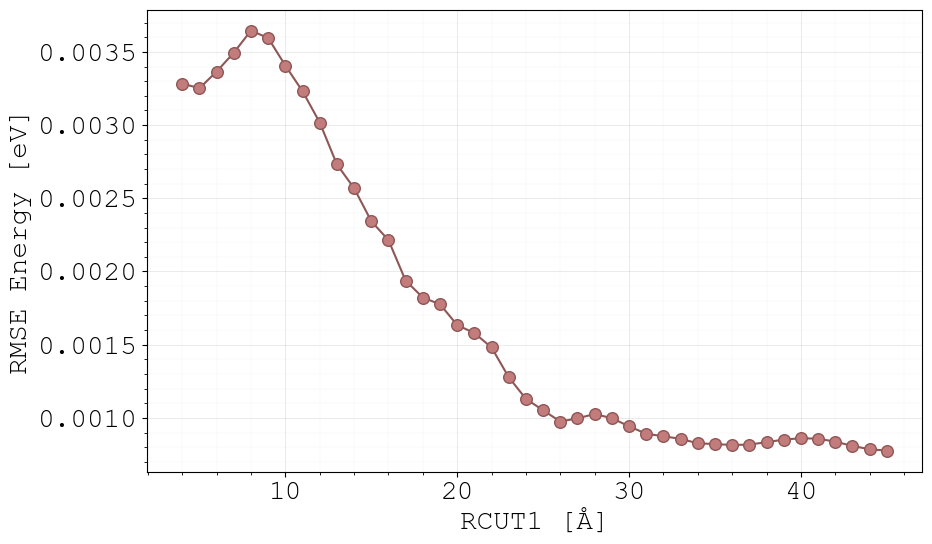

In [157]:
fig, ax = plt.subplots(figsize=(10, 6))

# Plot the volume data
ax.scatter(RCUT1_Number[:42], RCUT1_Energy[:42], label='RMSE Energy', color=dataset_colors[3],
            edgecolors=dataset_line_colors[3], s=70, marker='o', zorder=3)

ax.plot(RCUT1_Number[:42], RCUT1_Energy[:42], label='RMSE Energy', color = dataset_line_colors[3],
        linewidth=1.5, zorder=1)

# Set labels
ax.set(xlabel=r'RCUT1 [Å]', ylabel=r'RMSE Energy [eV]')

# Grid settings
ax.grid(True, which='major', linestyle='-', linewidth=0.75, alpha=0.25)
ax.minorticks_on()
ax.grid(True, which='minor', linestyle='-', linewidth=0.25, alpha=0.15)
ax.set_axisbelow(True)

plt.show()

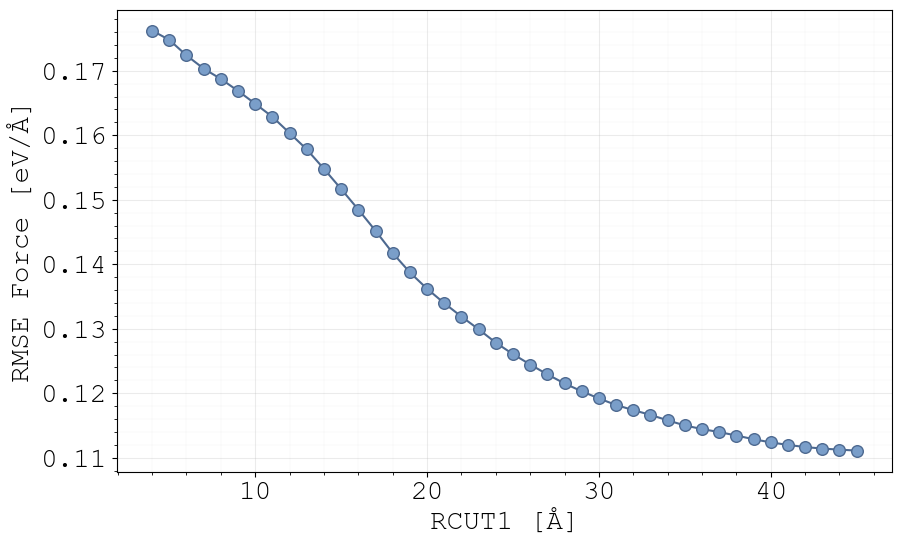

In [158]:
fig, ax = plt.subplots(figsize=(10, 6))

# Plot the volume data
ax.scatter(RCUT1_Number[:42], RCUT1_Force, label='RMSE Force', color=dataset_colors[4],
            edgecolors=dataset_line_colors[4], s=70, marker='o', zorder=3)

ax.plot(RCUT1_Number[:42], RCUT1_Force, label='RMSE Force', color = dataset_line_colors[4],
        linewidth=1.5, zorder=1)

# Set labels
ax.set(xlabel = r'RCUT1 [Å]', ylabel = r'RMSE Force [eV/Å]')

# Grid settings
ax.grid(True, which='major', linestyle='-', linewidth=0.75, alpha=0.25)
ax.minorticks_on()
ax.grid(True, which='minor', linestyle='-', linewidth=0.25, alpha=0.15)
ax.set_axisbelow(True)

plt.show()

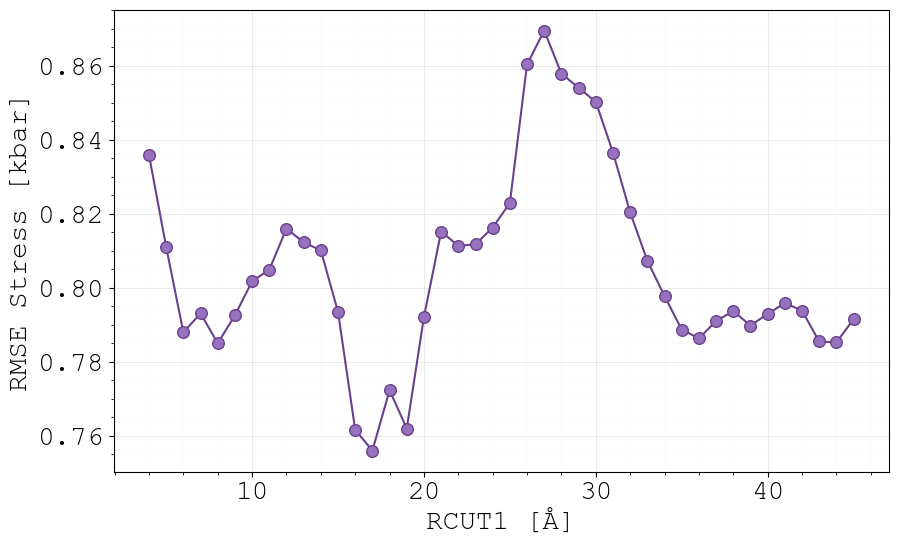

In [159]:
fig, ax = plt.subplots(figsize=(10, 6))

# Plot the volume data
ax.scatter(RCUT1_Number[:42], RCUT1_Stress, label='RMSE Stress', color=dataset_colors[0],
            edgecolors=dataset_line_colors[0], s=70, marker='o', zorder=3)

ax.plot(RCUT1_Number[:42], RCUT1_Stress, label='RMSE Force', color = dataset_line_colors[0],
        linewidth=1.5, zorder=1)

# Set labels
ax.set(xlabel = r'RCUT1 [Å]', ylabel = r'RMSE Stress [kbar]')

# Grid settings
ax.grid(True, which='major', linestyle='-', linewidth=0.75, alpha=0.25)
ax.minorticks_on()
ax.grid(True, which='minor', linestyle='-', linewidth=0.25, alpha=0.10)
ax.set_axisbelow(True)

plt.show()

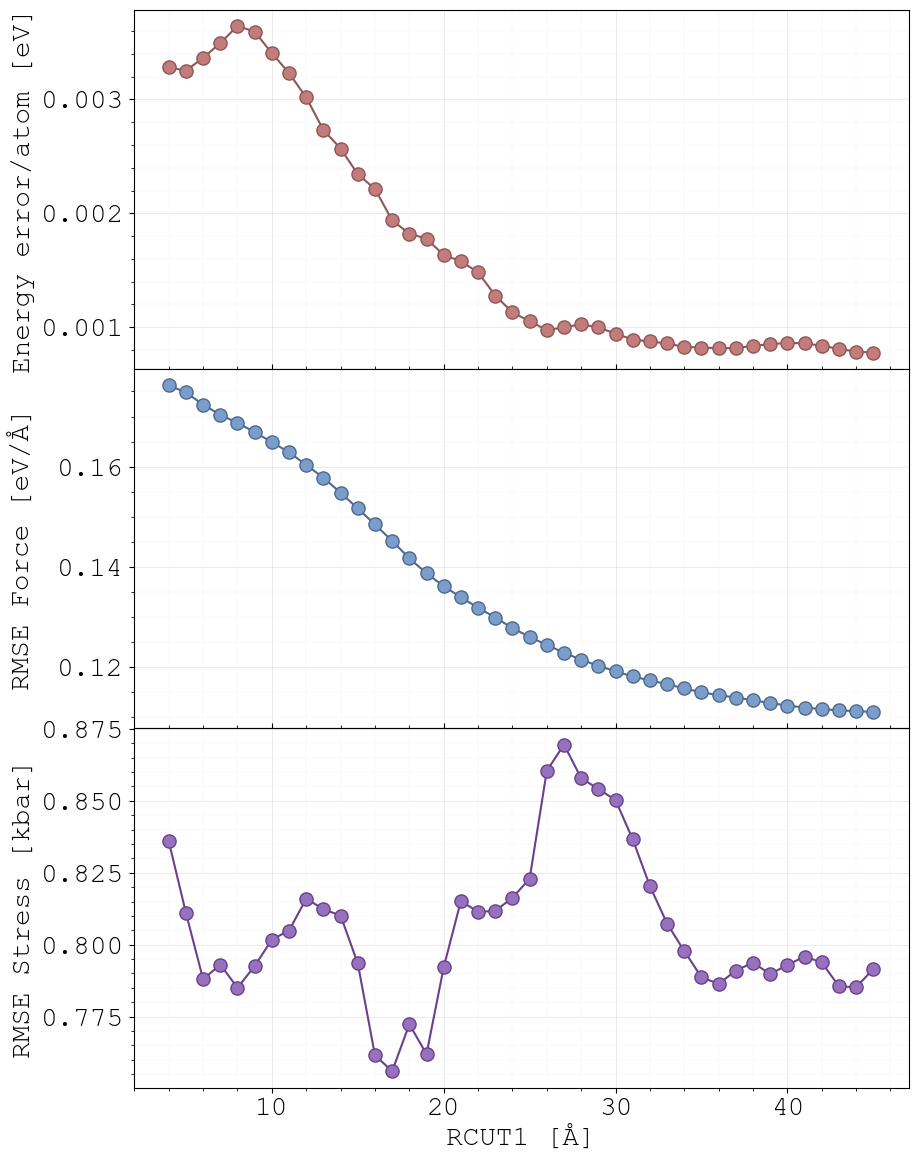

In [160]:
import matplotlib.pyplot as plt

# Create subplots sharing the x-axis
fig, axs = plt.subplots(nrows=3, ncols=1, figsize=(10, 14), sharex=True)

# --- First subplot: Energy Error ---
axs[0].scatter(RCUT1_Number[:42], RCUT1_Energy[:42], label='RMSE Energy', color=dataset_colors[3],
            edgecolors=dataset_line_colors[3], s=90, marker='o', zorder=3)
axs[0].plot(RCUT1_Number[:42], RCUT1_Energy[:42], label='RMSE Energy', color = dataset_line_colors[3],
        linewidth=1.5, zorder=1)

axs[0].set_ylabel(r'Energy error/atom [eV]')
axs[0].grid(True, which='major', linestyle='-', linewidth=0.75, alpha=0.25)
axs[0].minorticks_on()
axs[0].grid(True, which='minor', linestyle='-', linewidth=0.25, alpha=0.15)
axs[0].set_axisbelow(True)

# --- Second subplot: Force RMSE ---
axs[1].scatter(RCUT1_Number[:42], RCUT1_Force, label='RMSE Force', color=dataset_colors[4],
            edgecolors=dataset_line_colors[4], s=90, marker='o', zorder=3)
axs[1].plot(RCUT1_Number[:42], RCUT1_Force, label='RMSE Force', color = dataset_line_colors[4],
        linewidth=1.5, zorder=1)
axs[1].set_ylabel(r'RMSE Force [eV/Å]')
axs[1].grid(True, which='major', linestyle='-', linewidth=0.75, alpha=0.25)
axs[1].minorticks_on()
axs[1].grid(True, which='minor', linestyle='-', linewidth=0.25, alpha=0.15)
axs[1].set_axisbelow(True)

# --- Third subplot: Stress RMSE ---
axs[2].scatter(RCUT1_Number[:42], RCUT1_Stress, label='RMSE Stress', color=dataset_colors[0],
            edgecolors=dataset_line_colors[0], s=90, marker='o', zorder=3)
axs[2].plot(RCUT1_Number[:42], RCUT1_Stress, label='RMSE Force', color = dataset_line_colors[0],
        linewidth=1.5, zorder=1)
axs[2].set_ylabel(r'RMSE Stress [kbar]')
axs[2].set_xlabel('RCUT1 [Å]')
axs[2].grid(True, which='major', linestyle='-', linewidth=0.75, alpha=0.25)
axs[2].minorticks_on()
axs[2].grid(True, which='minor', linestyle='-', linewidth=0.25, alpha=0.15)
axs[2].set_axisbelow(True)

# Align layout
fig.align_ylabels(axs)
#plt.tight_layout()
plt.subplots_adjust(hspace=0.0)  # Reduce vertical space to make them feel joined
for ax in axs[1:]:
    ax.xaxis.set_tick_params(which='both', bottom=True, top=True)
fig.savefig("../tex-file/Figures/rcut1.png", dpi = 300, transparent = True, bbox_inches='tight')
plt.show()

<div class="header" style="text-align: center; margin-top: 20px; margin-bottom: 20px; font-family: Arial, sans-serif;">
    <h3>RCUT2 Results</h3>
</div>

In [161]:
# Get Energy, Force and Stress error data
RCUT2_Error = pd.read_csv(error_dir + "rcut2/training_error.dat", sep=r'\s+')
RCUT2_Error = RCUT2_Error.dropna()

# Split the data
RCUT2_Number = RCUT2_Error.iloc[:, 0].values
RCUT2_Energy = RCUT2_Error['energy'].astype(float).values
RCUT2_Force = RCUT2_Error['force'].values
RCUT2_Stress = RCUT2_Error['stress'].values

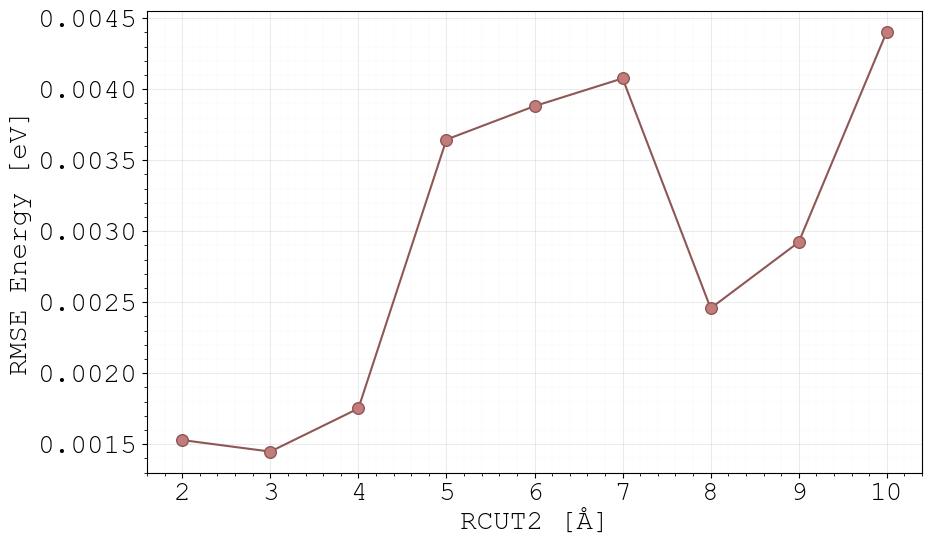

In [162]:
fig, ax = plt.subplots(figsize=(10, 6))

# Plot the volume data
ax.scatter(RCUT2_Number, RCUT2_Energy, label='RMSE Energy', color=dataset_colors[3],
            edgecolors=dataset_line_colors[3], s=70, marker='o', zorder=3)

ax.plot(RCUT2_Number, RCUT2_Energy, label='RMSE Energy', color = dataset_line_colors[3],
        linewidth=1.5, zorder=1)

# Set labels
ax.set(xlabel=r'RCUT2 [Å]', ylabel=r'RMSE Energy [eV]')

# Grid settings
ax.grid(True, which='major', linestyle='-', linewidth=0.75, alpha=0.25)
ax.minorticks_on()
ax.grid(True, which='minor', linestyle='-', linewidth=0.25, alpha=0.10)
ax.set_axisbelow(True)

plt.show()

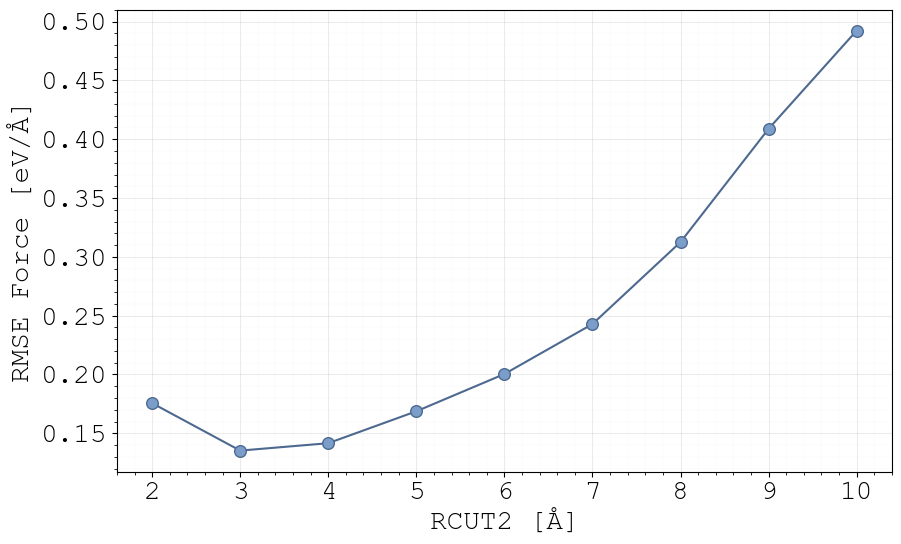

In [163]:
fig, ax = plt.subplots(figsize=(10, 6))

# Plot the volume data
ax.scatter(RCUT2_Number, RCUT2_Force, label='RMSE Force', color=dataset_colors[4],
            edgecolors=dataset_line_colors[4], s=70, marker='o', zorder=3)

ax.plot(RCUT2_Number, RCUT2_Force, label='RMSE Force', color = dataset_line_colors[4],
        linewidth=1.5, zorder=1)

# Set labels
ax.set(xlabel = r'RCUT2 [Å]', ylabel = r'RMSE Force [eV/Å]')

# Grid settings
ax.grid(True, which='major', linestyle='-', linewidth=0.75, alpha=0.25)
ax.minorticks_on()
ax.grid(True, which='minor', linestyle='-', linewidth=0.25, alpha=0.10)
ax.set_axisbelow(True)

plt.show()

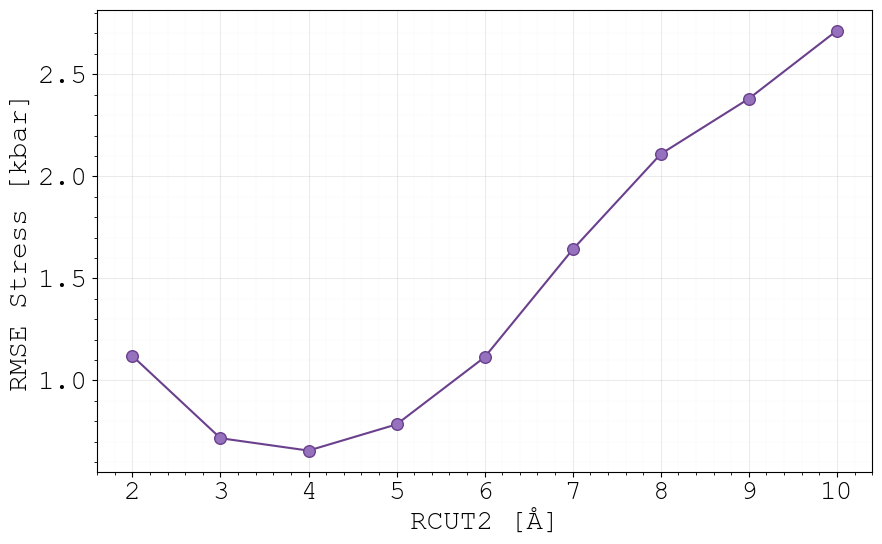

In [164]:
fig, ax = plt.subplots(figsize=(10, 6))

# Plot the volume data
ax.scatter(RCUT2_Number, RCUT2_Stress, label='RMSE Stress', color=dataset_colors[0],
            edgecolors=dataset_line_colors[0], s=70, marker='o', zorder=3)

ax.plot(RCUT2_Number, RCUT2_Stress, label='RMSE Force', color = dataset_line_colors[0],
        linewidth=1.5, zorder=1)

# Set labels
ax.set(xlabel = r'RCUT2 [Å]', ylabel = r'RMSE Stress [kbar]')

# Grid settings
ax.grid(True, which='major', linestyle='-', linewidth=0.75, alpha=0.25)
ax.minorticks_on()
ax.grid(True, which='minor', linestyle='-', linewidth=0.25, alpha=0.10)
ax.set_axisbelow(True)

plt.show()

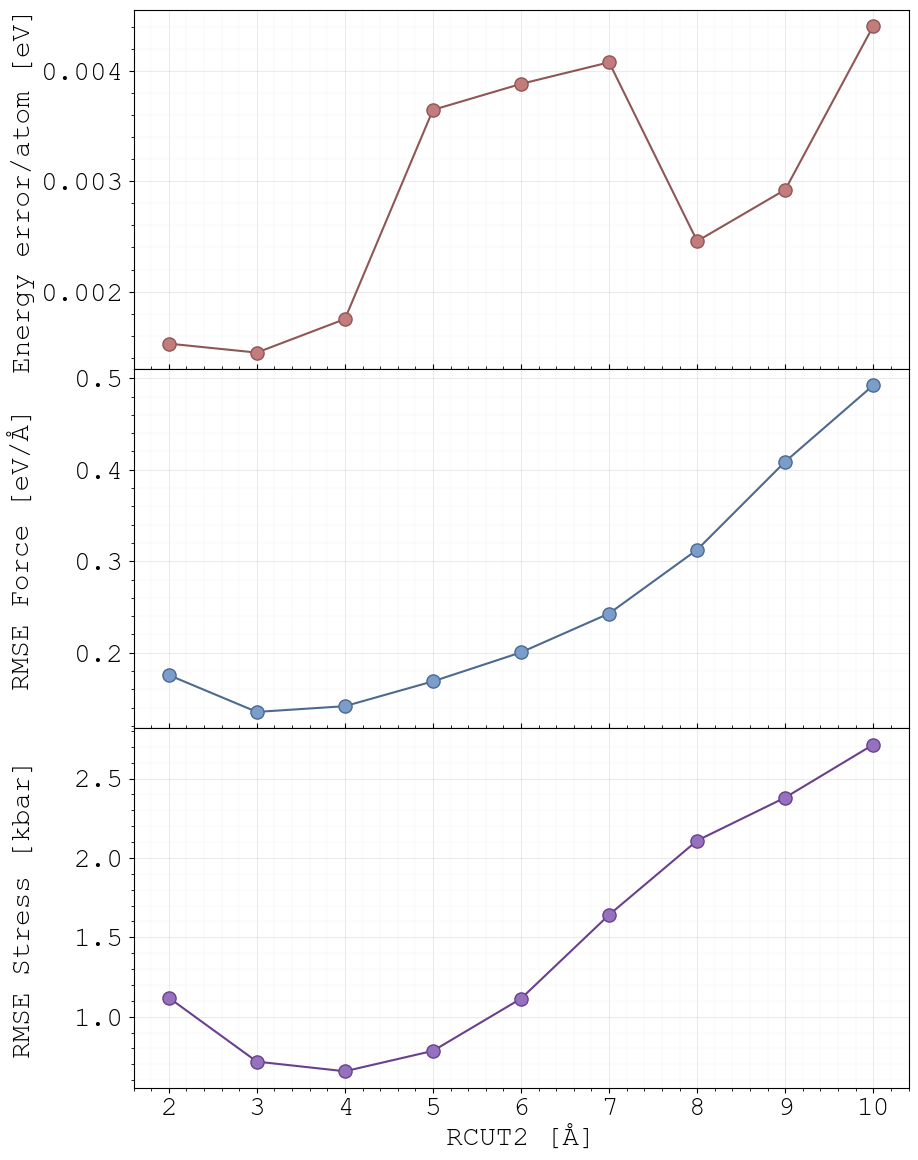

In [165]:
import matplotlib.pyplot as plt

# Create subplots sharing the x-axis
fig, axs = plt.subplots(nrows=3, ncols=1, figsize=(10, 14), sharex=True)

# --- First subplot: Energy Error ---
axs[0].scatter(RCUT2_Number, RCUT2_Energy, label='RMSE Energy', color=dataset_colors[3],
            edgecolors=dataset_line_colors[3], s=90, marker='o', zorder=3)
axs[0].plot(RCUT2_Number, RCUT2_Energy, label='RMSE Energy', color = dataset_line_colors[3],
        linewidth=1.5, zorder=1)

axs[0].set_ylabel(r'Energy error/atom [eV]')
axs[0].grid(True, which='major', linestyle='-', linewidth=0.75, alpha=0.25)
axs[0].minorticks_on()
axs[0].grid(True, which='minor', linestyle='-', linewidth=0.25, alpha=0.15)
axs[0].set_axisbelow(True)

# --- Second subplot: Force RMSE ---
axs[1].scatter(RCUT2_Number, RCUT2_Force, label='RMSE Force', color=dataset_colors[4],
            edgecolors=dataset_line_colors[4], s=90, marker='o', zorder=3)
axs[1].plot(RCUT2_Number, RCUT2_Force, label='RMSE Force', color = dataset_line_colors[4],
        linewidth=1.5, zorder=1)
axs[1].set_ylabel(r'RMSE Force [eV/Å]')
axs[1].grid(True, which='major', linestyle='-', linewidth=0.75, alpha=0.25)
axs[1].minorticks_on()
axs[1].grid(True, which='minor', linestyle='-', linewidth=0.25, alpha=0.15)
axs[1].set_axisbelow(True)

# --- Third subplot: Stress RMSE ---
axs[2].scatter(RCUT2_Number, RCUT2_Stress, label='RMSE Stress', color=dataset_colors[0],
            edgecolors=dataset_line_colors[0], s=90, marker='o', zorder=3)
axs[2].plot(RCUT2_Number, RCUT2_Stress, label='RMSE Force', color = dataset_line_colors[0],
        linewidth=1.5, zorder=1)
axs[2].set_ylabel(r'RMSE Stress [kbar]')
axs[2].set_xlabel('RCUT2 [Å]')
axs[2].grid(True, which='major', linestyle='-', linewidth=0.75, alpha=0.25)
axs[2].minorticks_on()
axs[2].grid(True, which='minor', linestyle='-', linewidth=0.25, alpha=0.15)
axs[2].set_axisbelow(True)

# Align layout
fig.align_ylabels(axs)
#plt.tight_layout()
plt.subplots_adjust(hspace=0.0)  # Reduce vertical space to make them feel joined
for ax in axs[1:]:
    ax.xaxis.set_tick_params(which='both', bottom=True, top=True)
fig.savefig("../tex-file/Figures/rcut2.png", dpi = 300, transparent = True, bbox_inches='tight')
plt.show()

<div class="header" style="text-align: center; margin-top: 20px; margin-bottom: 20px; font-family: Arial, sans-serif;">
    <h2>
        Equation of State (EOS) Models
    </h2>
</div>

<div style="text-align: justify; margin-bottom: 20px; font-family: Arial, sans-serif;">
    <p>
        The time has come to use our MLFF model to predict the mechanical properties of the CSH structure. For this, we attempted multiple approaches:
    </p>
    <ul>
        <li>Refitted MLFF Model 1 + Initial CSH structure</li>
        <li>Refitted MLFF Model 2 + Initial CSH structure</li>
        <li>Original MLFF Model + Initial CSH structure</li>
        <li>Original MLFF Model + Simulated Annealing (SA) CSH structure</li>
    </ul>
    <p>
        For this, we use the Third Order Birch-Murnaghan Equation of State (EOS) model, which is a widely used model for predicting the mechanical properties of materials. The EOS model allows us to calculate the bulk modulus, shear modulus, and other mechanical properties of the CSH structure.
    </p>
</div>

$$
\begin{equation}
     E(V) = E_0 + \frac{9}{16} V_0 B_0 \left[ \left( \left( \frac{V_0}{V} \right)^{2/3} - 1 \right)^3 B_0' + \left( \left( \frac{V_0}{V} \right)^{2/3} - 1 \right)^2 \left(6 - 4 \left( \frac{V_0}{V} \right)^{2/3} \right) \right]
\end{equation}
$$

In [166]:
# Define the EOS function 
def EOSModel(V, E0, V0, B0, B1):
    """
    Equation of State (EOS) model for energy as a function of volume.
    
    Parameters:
        - V (np.array) : Volume data 
        - E0 (float)  : Energy at equilibrium volume
        - V0 (float)  : Equilibrium volume
        - B0 (float)  : Bulk modulus at equilibrium volume
        - B1 (float)  : Pressure derivative of the bulk modulus

    Returns:
        - E (np.array) : Calculated energy values based on the EOS model
    """
    ETA = (V0 / V) ** (2/3)
    DELTA = ETA - 1
    E = E0 + (9 * B0 * V0 / 16) * (DELTA**3 * B1 + DELTA**2 * (6 - 4 * ETA))

    return E

In [167]:
# POSCAR file 
CSH_rxo = "../cluster-files/CONTCAR-cem1.rxo"

POSCAR_RX0 = ReadPoscarFile(CSH_rxo)
v_min = POSCAR_RX0.volume * (1 - 0.02)  # 2% below the equilibrium volume
v_max = POSCAR_RX0.volume * (1 + 0.02)  # 2% above the equilibrium volume

In [168]:
# Round v_min and v_max to the nearest 20
v_start = np.floor(v_min / 20) * 20
v_end   = np.ceil(v_max / 20) * 20

# Create range and format with 2 decimal places
v_range = np.arange(v_start, v_end + 1, 20)

print("Volume range:", v_range)


Volume range: [7320. 7340. 7360. 7380. 7400. 7420. 7440. 7460. 7480. 7500. 7520. 7540.
 7560. 7580. 7600. 7620. 7640.]


In [169]:
import numpy as np

volume = 7472.73
v_min = volume * (1 - 0.02)
v_max = volume * (1 + 0.02)

# Round v_min and v_max to nearest 20 to match Mathematica Range behavior
v_start = np.floor(v_min)
v_end = np.ceil(v_max)

# Create range and format with 2 decimal places
v_range = np.arange(v_start, v_end + 1, 20)
formatted = " ".join(f"{v:.2f}" for v in v_range)

print("Volume range:", formatted)


Volume range: 7323.00 7343.00 7363.00 7383.00 7403.00 7423.00 7443.00 7463.00 7483.00 7503.00 7523.00 7543.00 7563.00 7583.00 7603.00 7623.00


In [170]:
class MyEOSFitter:
    def __init__(self, eos_data_file: str, normalise: bool = True):
        self.volume = None 
        self.energy = None
        self.opt_params = None
        self.energy_fit = None 
        self.volume_fit = None
        self._ReadEOS(eos_data_file)

    def _ReadEOS(self, file_path: str) -> None:
        data = pd.read_csv(file_path, sep = r'\s+', header = None)
        self.volume = data.iloc[:, 0].values
        self.energy = data.iloc[:, 1].values

    def GetFitParams(self, anzat: list = None, start: int = 0, end: int = -1) -> list:
        self.start = start
        self.end = end if end != -1 else len(self.volume)

        self.opt_params, _ = curve_fit(EOSModel, self.volume[self.start:self.end],
                                  self.energy[self.start:self.end], anzat)

        names = [
                "E₀",
                "V₀",
                "B₀",
                "B₁",
                "B₀"
                ]
        units = ["eV", "Å³", "eV/Å³", "", "GPa"]
        params = [
                self.opt_params[0],
                self.opt_params[1],
                self.opt_params[2],
                self.opt_params[3],
                self.opt_params[2] * 160.21766208  # B₀ converted to GPa
                ]

        data = pd.DataFrame({
                'Parameter': names,
                'Value'    : [f"{param:.2f}" for param in params],  # use f-string formatting
                'Unit'     : units
                })

        print(tabulate(data, headers='keys', tablefmt='fancy_grid', showindex=False))

        return 
    

    def ShowFittedEOS(self, labels: list, normalise: bool = False, limits: list = None, save: list = [False], format = 'pdf') -> None:

        # Create a range of volumes for plotting 
        if limits is not None:
            self.volume_fit = np.linspace(self.volume[limits[0]], self.volume[limits[1] - 1], 100)
        else:
            end_idx = self.end if self.end is not None else -1
            self.volume_fit = np.linspace(self.volume[self.start], self.volume[end_idx - 1], 100)
            
        # Calculate the fitted energy using the EOS model 
        self.energy_fit = EOSModel(self.volume_fit, *self.opt_params)
        
        # Plot the Fitteted EOS
        fig, ax = plt.subplots(figsize = (8, 8))
        
        # Disable scientific and offset notation
        formatter = ScalarFormatter(useOffset=False, useMathText=False)
        formatter.set_scientific(False)

        # Set formatter for both axes
        ax.xaxis.set_major_formatter(formatter)
        ax.yaxis.set_major_formatter(formatter)

        # Plot original data as scatter points
        ax.scatter(self.volume[self.start if limits is None else limits[0]:self.end if limits is None else limits[1]], 
                   self.energy[self.start if limits is None else limits[0]:self.end if limits is None else limits[1]] / POSCAR_RX0.n_atoms 
                   if normalise else self.energy[self.start if limits is None else limits[0]:self.end if limits is None else limits[1]],
                   label      = labels[0], 
                   color      = dataset_colors[0],
                   edgecolors = dataset_line_colors[0], 
                   s          = 90, 
                   marker     = 'o', 
                   zorder     = 3)
        
        # Plot fitted EOS line
        ax.plot(self.volume_fit,
                self.energy_fit / POSCAR_RX0.n_atoms if normalise else self.energy_fit, 
                label     = labels[1], 
                color     = regression_color,
                linewidth = 2.6, 
                linestyle = '--', 
                zorder    = 2) 

        ax.set(xlabel = r'Volume [$\AA^3$]', 
               ylabel = 'Energy [eV/atom]' if normalise else 'Energy [eV]')
        ax.grid(True, 
                which     = 'major', 
                linestyle = '-', 
                linewidth = 0.75, 
                alpha     = 0.25)
        ax.minorticks_on()
        ax.grid(True, 
                which     = 'minor', 
                linestyle = '-', 
                linewidth = 0.25, 
                alpha     = 0.15)
        ax.set_axisbelow(True) 

        # # Set legend
        handles, labels = ax.get_legend_handles_labels()
        desired_order = [0, 1]
        ax.legend(
            [handles[i] for i in desired_order],
            [labels[i] for i in desired_order],
            loc            = 'upper center',
            bbox_to_anchor = (0.5, 1.10),  # place legend above the axes, centered
            ncol           = 4,    
            handletextpad  = 0.2,                   # spread legend entries horizontally
            frameon        = False                  # remove legend border/frame
        )
        if save[0]:
            if format == 'pdf':
                fig.savefig(save[1] + ".pdf")
            elif format == 'png':
                fig.savefig(save[1] + ".png", dpi = 300, transparent = True, bbox_inches='tight', pad_inches=0.1)
        
        plt.show()
        fig.clear()
        plt.close(fig)

<div class="header" style="text-align: center; margin-top: 20px; margin-bottom: 20px; font-family: Arial, sans-serif;">
    <h3>
    Refitted MLFF Model 1 + Initial CSH structure (RCUT1=36 & RCUT2=4)
    </h3>
</div>

In [171]:
# Get the volume-energy data
eos_400K_dir = "../cluster-files/ml-400k/eos-mlff-refit/"
anzat = [-4879, POSCAR_RX0.volume, -0.5, 4]

In [172]:
# Load the EOS data for ML1
EOS_ML1 = MyEOSFitter(eos_400K_dir + "volume-m1-4.dat")

# Get the fit parameters for ML1
EOS_ML1.GetFitParams(anzat = anzat, start = 0, end = 11)

╒═════════════╤══════════╤════════╕
│ Parameter   │    Value │ Unit   │
╞═════════════╪══════════╪════════╡
│ E₀          │ -4896.74 │ eV     │
├─────────────┼──────────┼────────┤
│ V₀          │  7275.89 │ Å³     │
├─────────────┼──────────┼────────┤
│ B₀          │     0.36 │ eV/Å³  │
├─────────────┼──────────┼────────┤
│ B₁          │     1.83 │        │
├─────────────┼──────────┼────────┤
│ B₀          │    57.51 │ GPa    │
╘═════════════╧══════════╧════════╛


In [173]:
EOS_ML1.GetFitParams(anzat = anzat, start = 0, end = -1)

╒═════════════╤══════════╤════════╕
│ Parameter   │    Value │ Unit   │
╞═════════════╪══════════╪════════╡
│ E₀          │ -4896.74 │ eV     │
├─────────────┼──────────┼────────┤
│ V₀          │  7276.16 │ Å³     │
├─────────────┼──────────┼────────┤
│ B₀          │     0.36 │ eV/Å³  │
├─────────────┼──────────┼────────┤
│ B₁          │    -6.01 │        │
├─────────────┼──────────┼────────┤
│ B₀          │    58.08 │ GPa    │
╘═════════════╧══════════╧════════╛


In [174]:
EOS_ML1.GetFitParams(anzat = anzat, start = 0, end = 13)

╒═════════════╤══════════╤════════╕
│ Parameter   │    Value │ Unit   │
╞═════════════╪══════════╪════════╡
│ E₀          │ -4896.74 │ eV     │
├─────────────┼──────────┼────────┤
│ V₀          │  7276.16 │ Å³     │
├─────────────┼──────────┼────────┤
│ B₀          │     0.36 │ eV/Å³  │
├─────────────┼──────────┼────────┤
│ B₁          │    -5.45 │        │
├─────────────┼──────────┼────────┤
│ B₀          │    57.88 │ GPa    │
╘═════════════╧══════════╧════════╛


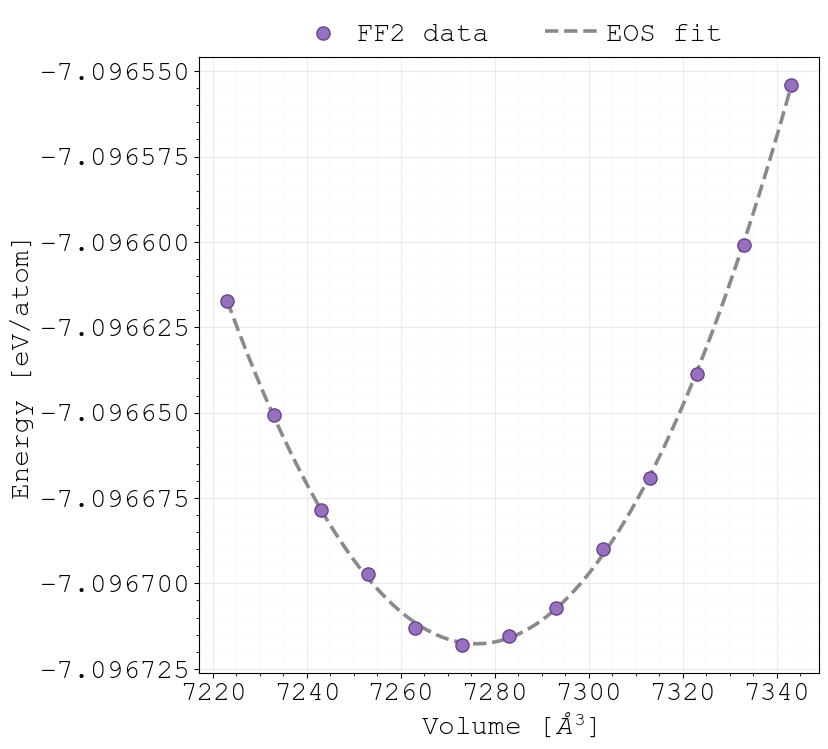

In [175]:
EOS_ML1.ShowFittedEOS(labels = ['FF2 data', 'EOS fit'], normalise = True, save = 
                      [True, "../tex-file/Figures/EOS-FF2"], format = 'png')

<div class="header" style="text-align: center; margin-top: 20px; margin-bottom: 20px; font-family: Arial, sans-serif;">
    <h3>
    Refitted MLFF Model 2 + Initial CSH structure (RCUT1=17 & RCUT2=4)
    </h3>
</div>

In [176]:
# Load the EOS data for ML1
EOS_ML2 = MyEOSFitter(eos_400K_dir + "volume-m2-3.dat")

In [177]:
EOS_ML2.GetFitParams(anzat = anzat, start = 2, end = -1)

╒═════════════╤══════════╤════════╕
│ Parameter   │    Value │ Unit   │
╞═════════════╪══════════╪════════╡
│ E₀          │ -4897.9  │ eV     │
├─────────────┼──────────┼────────┤
│ V₀          │  7312.8  │ Å³     │
├─────────────┼──────────┼────────┤
│ B₀          │     0.32 │ eV/Å³  │
├─────────────┼──────────┼────────┤
│ B₁          │     9.8  │        │
├─────────────┼──────────┼────────┤
│ B₀          │    51.14 │ GPa    │
╘═════════════╧══════════╧════════╛


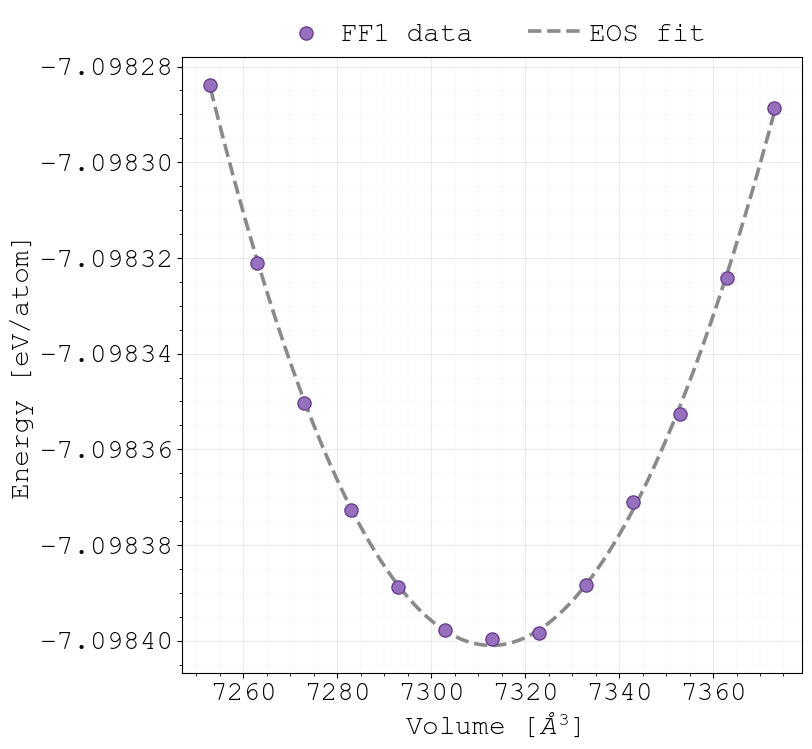

In [178]:
EOS_ML2.ShowFittedEOS(labels = ['FF1 data', 'EOS fit'], normalise = True, save = 
                      [True, "../tex-file/Figures/EOS-FF1"], format = 'png')

<div class="header" style="text-align: center; margin-top: 20px; margin-bottom: 20px; font-family: Arial, sans-serif;">
    <h3>
    Original MLFF Model + Initial CSH structure
    </h3>
</div>

In [179]:
# Get the volume-energy data
eos_orig_400K_dir = "../cluster-files/ml-400k/eos-mlff-orig/"

In [180]:
# REFITTED MLFF 2 + INIT CSH STRUCTURE (RELAXED)
EOS_ML_0 = MyEOSFitter(eos_orig_400K_dir + "volume.dat")

In [181]:
EOS_ML_0.GetFitParams(anzat = anzat, start = 0, end = -1)

╒═════════════╤══════════╤════════╕
│ Parameter   │    Value │ Unit   │
╞═════════════╪══════════╪════════╡
│ E₀          │ -4893.35 │ eV     │
├─────────────┼──────────┼────────┤
│ V₀          │  7302.49 │ Å³     │
├─────────────┼──────────┼────────┤
│ B₀          │     0.35 │ eV/Å³  │
├─────────────┼──────────┼────────┤
│ B₁          │     3.96 │        │
├─────────────┼──────────┼────────┤
│ B₀          │    55.72 │ GPa    │
╘═════════════╧══════════╧════════╛


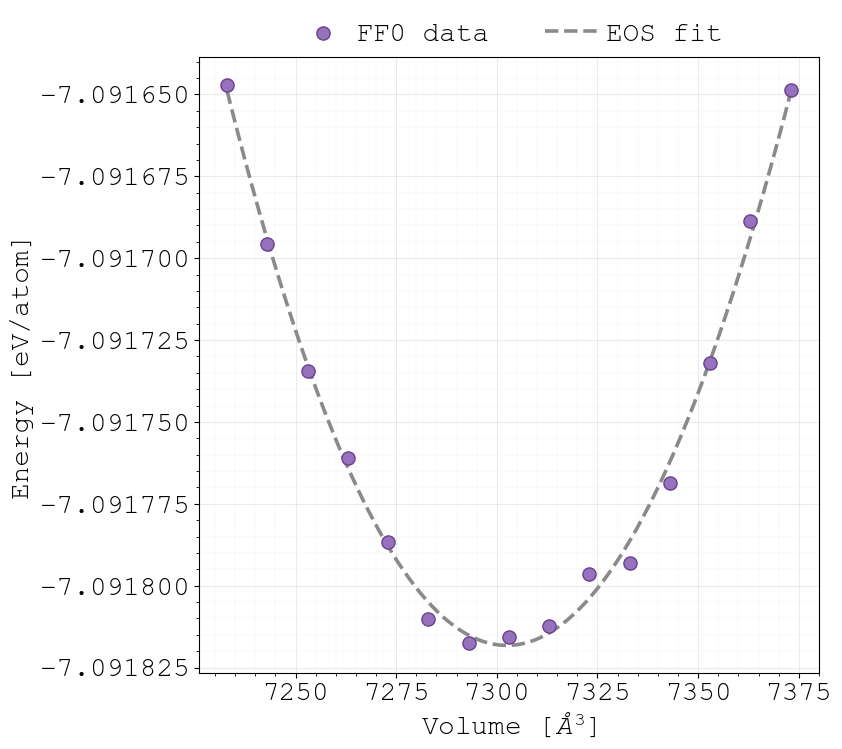

In [182]:
EOS_ML_0.ShowFittedEOS(labels = ['FF0 data', 'EOS fit'], normalise = True, limits = [0, 15], save =
                       [True, "../tex-file/Figures/EOS-FF0"], format = 'png')

<div class="header" style="text-align: center; margin-top: 20px; margin-bottom: 20px; font-family: Arial, sans-serif;">
    <h3>
    Original MLFF Model + Simulated Annealing (SA) CSH structure
    </h3>
</div>

In [183]:
# Get the volume-energy data
eos_sa_400K_dir = "../cluster-files/ml-400k/eos-sa/"

In [184]:
# Create a new instance of MyEOSFitter for the SA data
EOS_SA_EDIFF_005 = MyEOSFitter(eos_sa_400K_dir + "volume-sa-1.dat")

In [185]:
# Get the fit parameters for SA data
EOS_SA_EDIFF_005.GetFitParams(anzat = anzat, start = 0, end = -1)

╒═════════════╤══════════╤════════╕
│ Parameter   │    Value │ Unit   │
╞═════════════╪══════════╪════════╡
│ E₀          │ -4909.54 │ eV     │
├─────────────┼──────────┼────────┤
│ V₀          │  7356.09 │ Å³     │
├─────────────┼──────────┼────────┤
│ B₀          │     0.34 │ eV/Å³  │
├─────────────┼──────────┼────────┤
│ B₁          │     9.61 │        │
├─────────────┼──────────┼────────┤
│ B₀          │    55.12 │ GPa    │
╘═════════════╧══════════╧════════╛


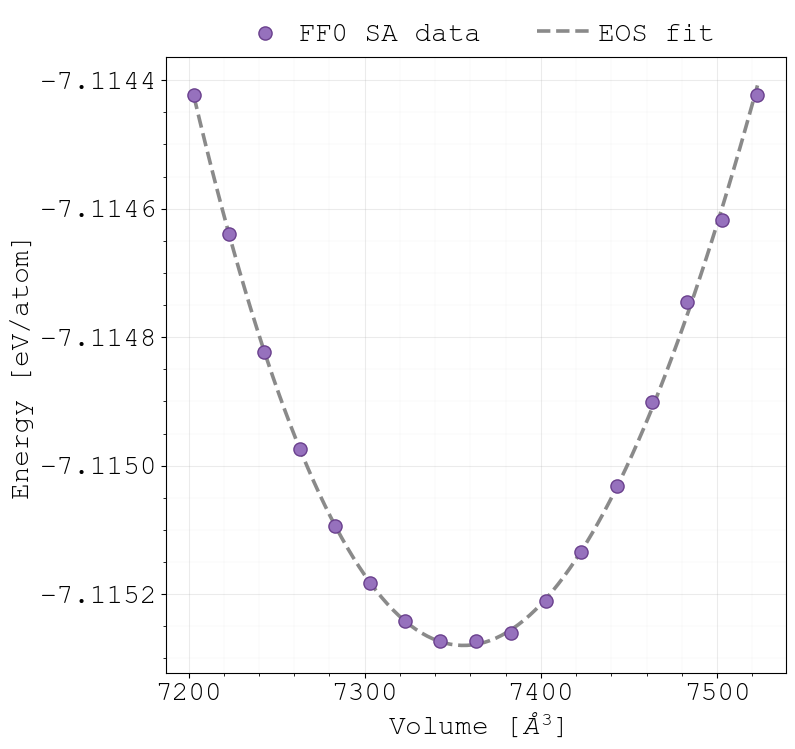

In [203]:
# Plot the fitted EOS for SA data
EOS_SA_EDIFF_005.ShowFittedEOS(labels = ['FF0 SA data', 'EOS fit'], normalise = True, limits = [0, 17], save =
                               [True, "../tex-file/Figures/EOS-SA-FF0"], format = 'png')

In [187]:
# Second SA data with different EDIFF
EOS_SA_EDIFF_02 = MyEOSFitter(eos_sa_400K_dir + "volume.dat")

# Get the fit parameters for the second SA data
EOS_SA_EDIFF_02.GetFitParams(anzat = anzat, start = 4, end = -1)

╒═════════════╤══════════╤════════╕
│ Parameter   │    Value │ Unit   │
╞═════════════╪══════════╪════════╡
│ E₀          │ -4909.53 │ eV     │
├─────────────┼──────────┼────────┤
│ V₀          │  7354.95 │ Å³     │
├─────────────┼──────────┼────────┤
│ B₀          │     0.38 │ eV/Å³  │
├─────────────┼──────────┼────────┤
│ B₁          │     8.79 │        │
├─────────────┼──────────┼────────┤
│ B₀          │    60.74 │ GPa    │
╘═════════════╧══════════╧════════╛


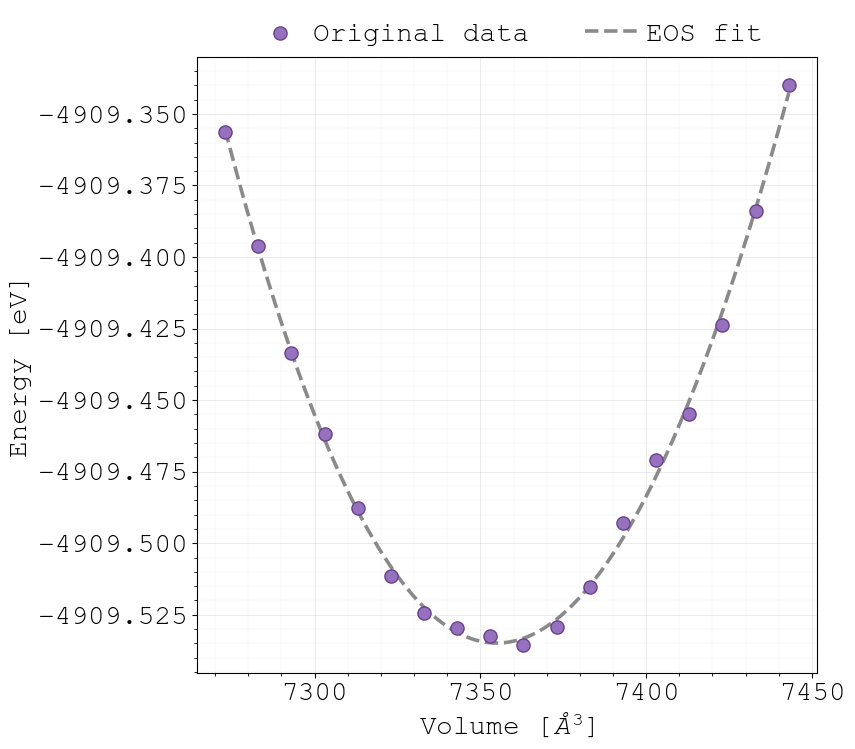

In [188]:
EOS_SA_EDIFF_02.ShowFittedEOS(labels = ['Original data', 'EOS fit'], normalise = False,
                               save = [True, "../tex-file/Figures/EOS_SA_EDIFF_02"], format = 'png')

<div class="header" style="text-align: center; margin-top: 20px; margin-bottom: 20px; font-family: Arial, sans-serif;">
    <h3>
    DFT - Equation of State (EOS) Model
    </h3>
</div>

In [189]:
# Get the volume-energy data
eos_dft_dir = "../cluster-files/ml-400k/eos-dft/"

In [190]:
# REFITTED MLFF 2 + INIT CSH STRUCTURE (RELAXED)
EOSDFT = pd.read_csv(eos_dft_dir + "volume.dat", sep=r'\s+', header=None)
EOSDFT_V = EOSDFT.iloc[:, 0].values
EOSDFT_E = EOSDFT.iloc[:, 1].values

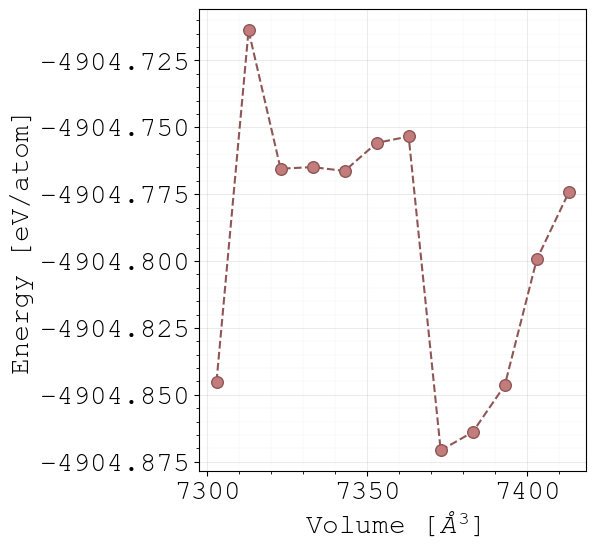

In [191]:
fig, ax = plt.subplots(figsize=(5, 6))

# Disable scientific and offset notation
formatter = ScalarFormatter(useOffset=False, useMathText=False)
formatter.set_scientific(False)

# Set formatter for both axes
ax.xaxis.set_major_formatter(formatter)
ax.yaxis.set_major_formatter(formatter)

# Plot the volume-energy data
ax.scatter(EOSDFT_V, EOSDFT_E, label='MLFF 1', color=dataset_colors[3],
            edgecolors=dataset_line_colors[3], s=70, marker='o', zorder=3)
#ax.plot(EOS400KML1_V[:12], EOS400KML1_E[:12], label='MLFF 1', color=dataset_line_colors[3],
        #linewidth=1.5, zorder=1)
# Plot the fitted EOS curve

ax.plot(EOSDFT_V, EOSDFT_E, label='Fitted EOS MLFF 1', color=dataset_line_colors[3], linestyle='--', zorder=2) 
# Set labels
ax.set(xlabel=r'Volume [$\AA^3$]', ylabel='Energy [eV/atom]')
# Grid settings
ax.grid(True, which='major', linestyle='-', linewidth=0.75, alpha=0.25)
ax.minorticks_on()
ax.grid(True, which='minor', linestyle='-', linewidth=0.25, alpha=0.15)
ax.set_axisbelow(True)  


plt.show()
fig.clear()
plt.close()

<div class="header" style="text-align: center; margin-top: 20px; margin-bottom: 20px; font-family: Arial, sans-serif;">
    <h3>
    Transferibility of MLFF & Thermal Expansion Coefficient
    </h3>
</div>

In [192]:
# Define a linear and quadratic model for fitting
def LinearModel(x, m, b):
    return m * x + b

def QuadraticModel(x, a, b, c):
    return a * x**2 + b * x + c

In [193]:
# Get the Volume-Temperature data
therm_400K_dir = "../cluster-files/ml-400k/thermal-exp/"

# Load the thermal expansion data
volume_temp = pd.read_csv(therm_400K_dir + "lattice_averages.dat", sep=r',')

In [194]:
volume_temp

,# Temp,Volume (A^3),LatVec1 (A),LatVec2 (A),LatVec3 (A),AvgLatVec (A)
0,200,7366.971389,13.081739,29.203004,23.280917,21.855220
1,250,7389.598137,13.075926,29.251349,23.301397,21.876224
2,300,7398.583254,13.166969,29.286408,23.148161,21.867180
3,350,7425.001855,13.177009,29.325626,23.113837,21.872157
4,400,7467.368895,13.311655,29.478730,23.165946,21.985444


In [195]:
# Carry out the liner and quadratic fits
linear_params, _ = curve_fit(LinearModel, volume_temp['# Temp'], volume_temp['Volume (A^3)'])
quadratic_params, _ = curve_fit(QuadraticModel, volume_temp['# Temp'], volume_temp['Volume (A^3)'])

In [196]:
linear_params

array([4.72397460e-01, 7.26778547e+03])

In [197]:
# Predict the volume 
volume_array = np.linspace(volume_temp['# Temp'].min(), volume_temp['# Temp'].max(), 100)
volume_temp_pred_linear = LinearModel(volume_array, *linear_params)
volume_temp_pred_quadratic = QuadraticModel(volume_array, *quadratic_params)

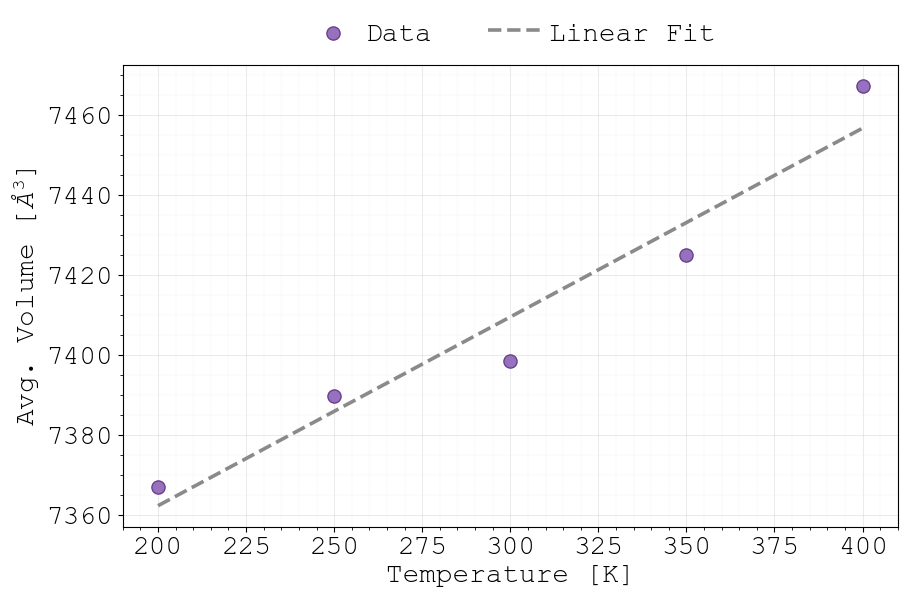

In [198]:
fig, ax = plt.subplots(figsize=(10, 6))

# Disable scientific and offset notation
formatter = ScalarFormatter(useOffset=False, useMathText=False)
formatter.set_scientific(False)

# Set formatter for both axes
ax.xaxis.set_major_formatter(formatter)
ax.yaxis.set_major_formatter(formatter)

# Plot the volume-energy data
ax.scatter(volume_temp['# Temp'], volume_temp['Volume (A^3)'], label='Data', color=dataset_colors[0],
            edgecolors=dataset_line_colors[0], s=90, marker='o', zorder=3)

# Plot the linear fit
ax.plot(volume_array, volume_temp_pred_linear, label = 'Linear Fit', color = regression_color,
         linewidth = 2.6 ,linestyle='--', zorder=2) 

# Set labels
ax.set(xlabel='Temperature [K]', ylabel=r'Avg. Volume [$\AA^3$]')
# Grid settings
ax.grid(True, which='major', linestyle='-', linewidth=0.75, alpha=0.25)
ax.minorticks_on()
ax.grid(True, which='minor', linestyle='-', linewidth=0.25, alpha=0.15)
ax.set_axisbelow(True)

handles, labels = ax.get_legend_handles_labels()
desired_order = [0, 1]
ax.legend(
    [handles[i] for i in desired_order],
    [labels[i] for i in desired_order],
    loc            = 'upper center',
    bbox_to_anchor = (0.5, 1.15),  # place legend above the axes, centered
    ncol           = 4,    
    handletextpad  = 0.2,                   # spread legend entries horizontally
    frameon        = False                  # remove legend border/frame
)

fig.savefig("../tex-file/Figures/expansion-coef.png", dpi = 300, transparent = True, bbox_inches='tight')
plt.show()
fig.clear()
plt.close()

In [214]:
# Compute the R_squared values for the fits
def compute_r_squared(y_data, y_pred):
    ss_res = np.sum((y_data - y_pred) ** 2)
    ss_tot = np.sum((y_data - np.mean(y_data)) ** 2)
    r_squared = 1 - (ss_res / ss_tot)
    return r_squared

In [215]:
# Get the R-squared values for both models
r_sqr_linear = compute_r_squared(volume_temp['Volume (A^3)'], LinearModel(volume_temp['# Temp'], *linear_params))
r_sqr_quadratic = compute_r_squared(volume_temp['Volume (A^3)'], QuadraticModel(volume_temp['# Temp'], *quadratic_params))

In [216]:
# Report the R-squared values
print(f"R-squared for Linear Fit: {r_sqr_linear:.4f}")
print(f"R-squared for Quadratic Fit: {r_sqr_quadratic:.4f}")

R-squared for Linear Fit: 0.9435
R-squared for Quadratic Fit: 0.9826


In [202]:
init_printing()  # Enables pretty printing in LaTeX

# Your fitted params
a1, b1 = linear_params
a2, b2, c2 = quadratic_params

# Define symbolic models
linear_expr = Eq(symbols('y'), a1 * x + b1)
quad_expr = Eq(symbols('y'), a2 * x**2 + b2 * x + c2)

# Display them in compiled LaTeX
display(linear_expr)
display(quad_expr)

In [217]:
# Compute the thermal expansion coefficients
alpha_linear = a1 / (volume_temp['Volume (A^3)'][0])
print(f"Thermal expansion coefficient (linear fit): {alpha_linear:.6f} 1/K")

Thermal expansion coefficient (linear fit): 0.000064 1/K


In [218]:
# Compute the thermal expansion coefficients for the quadratic fit
alpha_quadratic = (2 * a2 * volume_temp['Volume (A^3)'][0] + b2) / (volume_temp['Volume (A^3)'][0])
print(f"Thermal expansion coefficient (quadratic fit): {alpha_quadratic:.6f} 1/K")

Thermal expansion coefficient (quadratic fit): 0.003184 1/K
